# **Stock Portfolio Forecasting and Optimization on S&P500 Using Machine Learning and Search Methods**
<img src="images/pr.jpg" style="width:100%; height:100%;">

## **Abstract**  
Stock market forecasting and portfolio optimization are pivotal challenges in financial decision-making, driven by the volatility and complexity of markets like the S&P500. This project aims to develop an efficient system that predicts stock price trends and optimizes investment portfolios, leveraging historical S&P500 data from 2010 to 2023.  

The solution integrates traditional Machine Learning algorithms (e.g., Random Forest, SVM) for accurate stock price prediction. Furthermore, optimization techniques such as Monte Carlo simulations and genetic algorithms are employed to construct portfolios that maximize returns or minimize risks over a short-term investment horizon.  

By combining predictive analytics with optimization methodologies, this work provides insight for data-driven financial decision-making, promoting effective investment strategies. Ethical considerations and regulatory implications are also addressed, ensuring responsible and practical application in real-world financial contexts.

## **Introduction**
### **Context of the Problem**
The stock market is inherently volatile and complex, making it challenging for investors to forecast stock price trends and optimize investment decisions. Within the S&P500 index, the ability to predict stock movements and construct efficient portfolios is crucial for maximizing returns while managing risks. Traditional methods often fall short in addressing the rapid fluctuations and interdependencies inherent in financial markets, necessitating data-driven, adaptive solutions.

Machine Learning (ML) and Deep Learning (DL) have shown significant potential in addressing these challenges by analyzing large historical datasets, identifying patterns, and predicting trends with improved accuracy. Additionally, portfolio optimization techniques, such as Monte Carlo simulations and genetic algorithms, can help select investments that maximize returns or minimize risks based on forecasted trends. Combining these approaches can streamline decision-making, reduce human bias, and enhance financial performance.

### **Objective of the work**
This project aims to develop a robust framework for predicting stock price trends and optimizing investment portfolios within the S&P500 index. By leveraging ML algorithms models, the objective is to build accurate forecasting systems. These predictions will feed into optimization techniques to create well-balanced investment portfolios over a one-month horizon.

### **Structure of the work**
This notebook is structured as follows:
- Data Acquisition and EDA : We will collect historical price data for all S&P500 stocks from 2010 to January 2024 to build predictive models. Additionally, we will extract relevant financial indices such as moving averages, volatility, and trading volume, which can provide valuable insights into market trends. An Exploratory Data Analysis (EDA) will be conducted to study correlations, detect trends, and evaluate patterns within the data for the predictive modeling process.

- Stock Market Forecasting : This section focuses on developing multi-output forecasting models using traditional Machine Learning techniques such as Random Forest and Support Vector Machines (SVM). These models aim to predict the daily prices of all 500 stocks within the S&P500 index. The performance of each model will be compared using regression metrics such as Root Mean Square Error (RMSE), Mean Absolute Error (MAE), and Mean Absolute Percentage Error (MAPE) to determine their effectiveness.

- Model Hyperparameter Tuning : After identifying the most promising models, we will perform hyperparameter tuning to enhance their predictive accuracy further. Techniques such as grid search and randomized search will be employed, targeting optimal configurations for regression metrics. 

- Stock Portfolio Optimization: Building on the forecasting outputs, we will employ advanced optimization techniques, including Monte Carlo simulations and genetic algorithms, to construct efficient investment portfolios. The Monte Carlo simulations will model various potential scenarios to evaluate risk and return distributions, while genetic algorithms will optimize portfolio allocation by iteratively evolving toward the most profitable or least risky configurations. These methods will account for constraints such as diversification, transaction costs, and risk tolerance.

- Discussion and Future Work :  Finally, we will analyze the results, discussing the strengths and limitations of our methodology. This section will provide insights into the practical applications of our approach and suggest potential refinements, such as incorporating alternative datasets (e.g., economic indicators or sentiment analysis) or exploring novel optimization algorithms. Future research directions will aim to enhance both predictive accuracy and portfolio optimization for real-world financial challenges.

### Libraries

In [1]:
import os
from datetime import datetime
import time

# Data Manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Feature Selection
from sklearn.feature_selection import VarianceThreshold

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Decomposition
from sklearn.decomposition import IncrementalPCA, PCA

# Regressors
from sklearn.multioutput import MultiOutputRegressor
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, 
    ExtraTreesRegressor, BaggingRegressor, HistGradientBoostingRegressor
)
from sklearn.linear_model import (
    LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge, ARDRegression, 
    HuberRegressor, PassiveAggressiveRegressor, TheilSenRegressor, SGDRegressor, 
    PoissonRegressor, TweedieRegressor
)
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor

# Metrics
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error,make_scorer
)

# Gradient Boosting Libraries
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV


# Utility functions
from importlib import reload
import utils
reload(utils)

from utils import (
    extract_sp500_companies, extract_stock, process_data, 
    join_stock_data, join_macro, join_technical_indicators,mean_positive_error,
    transformar_a_tensor_3d, crear_ventanas_temporales
)


import torch
from torch.utils.data import DataLoader, TensorDataset


## **Data Acquisition**
As mentioned above, we will extract historical price data for all **current S&P500 stocks**. The list of stocks will be sourced from the S&P500 Wikipedia page, ensuring it reflects the most up-to-date composition of the index. Subsequently, we will utilize the Yahoo Finance API to retrieve the historical data for these stocks, covering the period from 2010 to January 2024. This dataset will include essential information such as daily opening and closing prices, trading volumes, and additional technical indicators. These data points will serve as the foundation for both the forecasting models and the portfolio optimization strategies.

### Extracting SP500 Companies

In [7]:
# URL de la página de Wikipedia
df = extract_sp500_companies()
companies = df['Símbolo']
df.head(5)




,Símbolo,Seguridad,Presentación ante la SEC,Sector GICS,Sub-industria GICS,Ubicación de la sede,Fecha de incorporación,Clave de índice central,Fundada
0,MMM,3M,reports,Industriales,Conglomerados Industriales,"Saint Paul, Minnesota",1976-08-09,66740,1902
1,AOS,A. O. Smith,reports,Industriales,Productos de Edificio,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,reports,Cuidado de Salud,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
3,A123,AbbVie,reports,Cuidado de Salud,Farmacéuticos,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,reports,Tecnología Informática,Consultoría Informática y Otros Servicios,"Dublin, Ireland",2011-07-06,1467373,1989


In [8]:


for stock in companies : 
    raw_stock_data = extract_stock(stock)
    if raw_stock_data is not None : 
        raw_stock_data.to_csv(f"data/raw_stocks/{stock}.csv")
        stock_data = process_data(f"data/raw_stocks/{stock}.csv")
        stock_data.to_csv(f"data/stocks/{stock}.csv")
    
stock_data.head()
    

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['A123']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed

No data found for A123.



[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ATVI']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


No data found for ATVI.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

No data found for ABC.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

No data found for BRK.B.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

No data found for CDAY.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

No data found for DISH.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

No data found for RE.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['FRC']: YFTzM

No data found for FRC.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['FLT']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


No data found for FLT.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

No data found for PEAK.



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******

No data found for PKI.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PXD']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


No data found for PXD.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

No data found for SBNY.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SIVB']: YFPr

No data found for SIVB.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

No data found for WRK.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Date,AdjustedClose,Close,High,Low,Open,Volume
0,2013-02-01 00:00:00+00:00,28.409882,31.010000,31.74,30.469999,31.50,66789100
1,2013-02-04 00:00:00+00:00,28.419044,31.020000,31.99,30.760000,31.09,7695400
2,2013-02-05 00:00:00+00:00,28.437363,31.040001,31.98,30.850000,31.25,5013200
3,2013-02-06 00:00:00+00:00,28.428202,31.030001,31.43,30.750000,30.98,2126100
4,2013-02-07 00:00:00+00:00,29.316872,32.000000,32.73,31.000000,31.00,3800800


In [9]:

print(f"Raw Files Retrieved : {len(os.listdir('data/raw_stocks/'))}, Processed Files : {len(os.listdir('data/stocks/'))}")
raw_folder = "data/raw_stocks/"
raw_files = [os.path.splitext(file)[0] for file in os.listdir(raw_folder) if file.endswith('.csv')]
missing_companies = [company for company in companies if company not in raw_files]
print(f"Companies without data : {missing_companies}")


Raw Files Retrieved : 500, Processed Files : 500
Companies without data : ['A123', 'ATVI', 'ABC', 'BRK.B', 'CDAY', 'DISH', 'RE', 'FRC', 'FLT', 'PEAK', 'PKI', 'PXD', 'SBNY', 'SIVB', 'WRK']


A total of 15 companies have been identified as requiring the use of alternative tickers, as the existing tickers are no longer available on the Yahoo Finance website. The following challenges were encountered:

- Berkshire Hathaway operates two distinct types of stocks, one targeting high-net-worth investors and another designed for those with more limited financial resources. Nevertheless, both types of stocks have been included in the dataset due to the critical importance of both stock classes to the company's financial structure.

- In contrast, First Republic Bank ceased operations in May 2023 due to a banking crisis, and thus, it will not be included in the dataset. Similarly, SVB Financial Group experienced a banking crisis and was removed from the index in March 2023, so it will also be excluded. 

- EchoStar Corporation acquired DISH Network Corporation on December 31, 2023. Following this merger, DISH shares were converted into EchoStar shares, and the "DISH" ticker symbol was removed from S&P500 listings.

In [10]:
reload(utils)
from utils import process_data
missing_companies_ticker=['ABBV','AIY.DE','COR','BRKA.VI','BRKB.VI','DAY','EG','CPAY','DOC','VST','BG','SWR.L']
for missing_stock in missing_companies_ticker: 
    raw_stock_data = extract_stock(missing_stock)
    if raw_stock_data is not None : 
        raw_stock_data.to_csv(f"data/raw_stocks/{missing_stock}.csv")
        stock_data = process_data(f"data/raw_stocks/{missing_stock}.csv")
        stock_data.to_csv(f"data/stocks/{missing_stock}.csv")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### **Merging Stock data and Macroeconomic data**

After obtaining individual CSV files containing data for each stock, our next step was to construct a unified, comprehensive dataset. Initially, we considered an approach where each company’s data would be arranged in contiguous blocks, with repeated date entries for each firm and only six columns : *Date*, *Close*, *AdjustedClose*, *Open*, *High*, and *Volume* in the original_data dataframe. While this method would keep the dataset structure relatively simple, we identified several drawbacks. First, this vertical stacking of time-series data for each company could prevent the model from capturing important **inter-company relationships**. Moreover, implementing such an arrangement would complicate the programming process and significantly increase computational demands.

Example of the vertical stacking : 

| Date       | Close  | AdjustedClose | Open   | High   | Volume   | Company |
|------------|---------|--------------|--------|--------|----------|---------|
| 2020-01-01 | 300.35 | 300.32       | 299.80 | 303.00 | 31,000   | AAPL    |
| 2020-01-02 | 302.20 | 302.18       | 301.50 | 305.10 | 25,500   | AAPL    |
| 2020-01-03 | 298.90 | 298.87       | 297.30 | 301.00 | 28,000   | AAPL    |
| ...        | ...    | ...          | ...    | ...    | ...      | AAPL    |
| 2020-01-01 | 150.10 | 150.08       | 149.70 | 151.50 | 20,000   | MSFT    |
| 2020-01-02 | 152.50 | 152.45       | 151.90 | 153.00 | 22,000   | MSFT    |
| 2020-01-03 | 149.90 | 149.85       | 149.00 | 150.80 | 18,500   | MSFT    |
| ...        | ...    | ...          | ...    | ...    | ...      | MSFT    |


To address these challenges, we opted to merge the CSV files for each stock **horizontally**, aligning their data by dates. In other words, we combined the datasets as additional columns rather than stacking them by rows. This horizontal integration enables the model to simultaneously analyze the time-series behavior of multiple stocks, thereby facilitating the discovery of cross-company correlations and interdependencies. By leveraging a richer information structure, the model is better positioned to uncover complex patterns and improve predictive accuracy. Ultimately, this approach not only enhances the model’s explanatory power but also reduces the computational overhead associated with more convoluted dataset configurations.

In [12]:
original_data     = join_stock_data(r"data/stocks",axis=True)
original_data['Date'] = pd.to_datetime(original_data['Date']).dt.tz_localize(None)


c:\Users\user\OneDrive - Universidad de Oviedo\Escritorio\UNI\3ºAÑO\LAB_IACD\Proyecto_2_Lab_IACD\Proyect2_LABIACD\utils.py:155: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final_dataset.reset_index(inplace=True)
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[

0      2010-01-04
1      2010-01-05
2      2010-01-06
3      2010-01-07
4      2010-01-08
          ...    
3632   2024-01-24
3633   2024-01-25
3634   2024-01-26
3635   2024-01-29
3636   2024-01-30
Name: Date, Length: 3637, dtype: datetime64[ns]

In [27]:
start = '2010-01-01'
end = '2024-01-31'
macro_data=join_macro(start,end)
raw_data = pd.merge(original_data, macro_data, on='Date', how='inner')
raw_data = raw_data.sort_values(by=[ 'Date']).reset_index(drop=True)
raw_data=raw_data[raw_data['Date'].notna()]



raw_data.bfill( inplace=True)
raw_data.ffill(inplace=True)


df = raw_data
# Iterar sobre todas las columnas menos 'Date'
for columna in df.columns:
    if columna not in ['Date'] :
        # Verificar valores no numéricos en la columna
        non_numeric_values = df[columna][~df[columna].apply(lambda x: isinstance(x, (int, float)))]
        # Convertir la columna a tipo numérico, forzando los errores a NaN
        df[columna] = pd.to_numeric(df[columna], errors='coerce')
        


volume_columns = [col for col in df.columns if "Volume" in col]
for col in volume_columns: 
    df[col]=np.log1p(df[col])

display(df)
print('Size of Horizontal Structure',raw_data.shape)


,Date,AdjustedClose_A,Close_A,High_A,Low_A,Open_A,Volume_A,AdjustedClose_AAL,Close_AAL,High_AAL,...,^FTSE,CL=F,SI=F,GC=F,^HSI,NG=F,ZC=F,EURUSD=X,BTC-USD,HO=F
0,2010-01-04,20.053032,22.389128,22.625179,22.267525,22.453505,3815561.0,4.496876,4.77,4.94,...,5500.299805,81.510002,17.440001,1117.699951,21823.279297,5.884,418.50,1.442398,457.334015,2.1905
1,2010-01-05,19.835201,22.145924,22.331903,22.002861,22.324751,4186031.0,5.005958,5.31,5.37,...,5522.500000,81.769997,17.781000,1118.099976,22279.580078,5.637,418.75,1.436596,457.334015,2.1941
2,2010-01-06,19.764729,22.067240,22.174536,22.002861,22.067240,3243779.0,4.798555,5.09,5.38,...,5530.000000,83.180000,18.163000,1135.900024,22416.669922,6.009,421.75,1.440403,457.334015,2.2032
3,2010-01-07,19.739101,22.038628,22.045780,21.816881,22.017166,3095172.0,4.939965,5.24,5.43,...,5526.700195,82.660004,18.333000,1133.099976,22269.449219,5.806,417.50,1.431803,457.334015,2.1836
4,2010-01-08,19.732687,22.031473,22.067240,21.745352,21.917025,3733918.0,4.845691,5.14,5.43,...,5534.200195,82.750000,18.458000,1138.199951,22296.750000,5.749,423.00,1.441109,457.334015,2.2003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3632,2024-01-24,129.123932,129.779999,132.800003,129.429993,132.410004,1141900.0,13.930000,13.93,14.18,...,7527.700195,75.089996,22.754999,2013.900024,15899.870117,2.641,452.25,1.085788,40077.074219,2.6818
3633,2024-01-25,129.223419,129.880005,131.429993,129.429993,131.110001,1120900.0,15.360000,15.36,15.46,...,7529.700195,77.360001,22.808001,2016.900024,16211.959961,2.571,451.75,1.088175,39933.808594,2.7954
3634,2024-01-26,130.327835,130.990005,134.229996,130.639999,133.710007,1319800.0,15.130000,15.13,15.84,...,7635.100098,78.010002,22.754999,2016.800049,15952.230469,2.712,446.25,1.084705,41816.871094,2.8434
3635,2024-01-29,132.158524,132.830002,132.899994,131.279999,131.750000,1407200.0,14.940000,14.94,15.39,...,7632.700195,76.779999,23.138000,2025.199951,16077.240234,2.490,440.25,1.084352,43288.246094,2.8339


### **Obtaining Technical Indicators**

In [29]:
reload(utils)

df2=df.copy()

df2['Date']=pd.to_datetime(df2['Date'],format="ISO8601")

datos_tecnicos=join_technical_indicators(database=df2,folder = r"data/stocks",axis=True)

df2 = pd.merge(df2, datos_tecnicos, on='Date', how='outer')
df2 = df2.sort_values(by=[ 'Date']).reset_index(drop=True)

df2['day']          = df2['Date'].dt.day.astype('float64')
df2['month']        = df2['Date'].dt.month.astype('float64')
df2['year']         = df2['Date'].dt.year.astype('float64')
df2['day_of_week']  = df2['Date'].dt.dayofweek.astype('float64')


# Filtrar y mostrar columnas con valores nulos en df2
null_columns_df2 = df2.isnull().sum()
print('Valores Nulos en Horizontal',null_columns_df2[null_columns_df2 > 0])

print('Duplicados: ',df2.duplicated().sum())

columnas_a_eliminar = [col for col in df2.columns if "Close_" in col and "AdjustedClose_" not in col]
df2 = df2.drop(columns=columnas_a_eliminar)
display(df2.head(20))


train=df2[df2['Date']<'2024-01-01']
test=df2[df2['Date']>='2024-01-01']

display(test['Date'])

train.to_csv('train.csv')
test.to_csv('test.csv')

Valores Nulos en Horizontal Series([], dtype: int64)
Duplicados:  0


,Date,AdjustedClose_A,High_A,Low_A,Open_A,Volume_A,AdjustedClose_AAL,High_AAL,Low_AAL,Open_AAL,...,MTM6_ZTS,MTM12_ZTS,ROC_ZTS,SMI_ZTS,WVAD_ZTS,RSI_ZTS,day,month,year,day_of_week
0,2010-01-04,20.053032,22.625179,22.267525,22.453505,15.154599,4.496876,4.94,4.66,4.84,...,0.0,0.0,0.0,42.519742,-6.951455,100.0,4.0,1.0,2010.0,0.0
1,2010-01-05,19.835201,22.331903,22.002861,22.324751,15.247264,5.005958,5.37,4.71,4.79,...,0.0,0.0,0.0,42.519742,-6.951455,100.0,5.0,1.0,2010.0,1.0
2,2010-01-06,19.764729,22.174536,22.002861,22.067240,14.992250,4.798555,5.38,5.00,5.19,...,0.0,0.0,0.0,42.519742,-6.951455,100.0,6.0,1.0,2010.0,2.0
3,2010-01-07,19.739101,22.045780,21.816881,22.017166,14.945354,4.939965,5.43,5.05,5.06,...,0.0,0.0,0.0,42.519742,-6.951455,100.0,7.0,1.0,2010.0,3.0
4,2010-01-08,19.732687,22.067240,21.745352,21.917025,15.132969,4.845691,5.43,5.06,5.27,...,0.0,0.0,0.0,42.519742,-6.951455,100.0,8.0,1.0,2010.0,4.0
5,2010-01-11,19.745510,22.210300,21.938484,22.088697,15.380282,4.751417,5.23,4.94,5.13,...,0.0,0.0,0.0,42.519742,-6.951455,100.0,11.0,1.0,2010.0,0.0
6,2010-01-12,19.508453,21.924177,21.616594,21.859800,14.870197,4.789126,5.15,4.96,5.06,...,0.0,0.0,0.0,42.519742,-6.951455,100.0,12.0,1.0,2010.0,1.0
7,2010-01-13,19.662220,22.017166,21.494993,21.795422,15.044844,5.166223,5.50,5.02,5.12,...,0.0,0.0,0.0,42.519742,-6.951455,100.0,13.0,1.0,2010.0,2.0
8,2010-01-14,19.956928,22.346209,21.816881,21.881260,15.634201,5.269925,5.71,5.41,5.46,...,0.0,0.0,0.0,42.519742,-6.951455,100.0,14.0,1.0,2010.0,3.0
9,2010-01-15,19.495636,22.432047,21.695278,22.331903,15.347351,5.185079,5.84,5.43,5.64,...,0.0,0.0,0.0,42.519742,-6.951455,100.0,15.0,1.0,2010.0,4.0


3616   2024-01-02
3617   2024-01-03
3618   2024-01-04
3619   2024-01-05
3620   2024-01-08
3621   2024-01-09
3622   2024-01-10
3623   2024-01-11
3624   2024-01-12
3625   2024-01-15
3626   2024-01-16
3627   2024-01-17
3628   2024-01-18
3629   2024-01-19
3630   2024-01-22
3631   2024-01-23
3632   2024-01-24
3633   2024-01-25
3634   2024-01-26
3635   2024-01-29
3636   2024-01-30
Name: Date, dtype: datetime64[ns]

In [30]:


print('Dimensión de train :',train.shape)
display('Información de train :')
train.info()
display(train.columns)

print('Dimensión de test :',test.shape)
display('Información de test :')
test.info()
display(test.columns)



Dimensión de train : (3616, 9535)


'Información de train :'

<class 'pandas.core.frame.DataFrame'>
Index: 3616 entries, 0 to 3615
Columns: 9535 entries, Date to day_of_week
dtypes: datetime64[ns](1), float64(9534)
memory usage: 263.1 MB


Index(['Date', 'AdjustedClose_A', 'High_A', 'Low_A', 'Open_A', 'Volume_A',
       'AdjustedClose_AAL', 'High_AAL', 'Low_AAL', 'Open_AAL',
       ...
       'MTM6_ZTS', 'MTM12_ZTS', 'ROC_ZTS', 'SMI_ZTS', 'WVAD_ZTS', 'RSI_ZTS',
       'day', 'month', 'year', 'day_of_week'],
      dtype='object', length=9535)

Dimensión de test : (21, 9535)


'Información de test :'

<class 'pandas.core.frame.DataFrame'>
Index: 21 entries, 3616 to 3636
Columns: 9535 entries, Date to day_of_week
dtypes: datetime64[ns](1), float64(9534)
memory usage: 1.5 MB


Index(['Date', 'AdjustedClose_A', 'High_A', 'Low_A', 'Open_A', 'Volume_A',
       'AdjustedClose_AAL', 'High_AAL', 'Low_AAL', 'Open_AAL',
       ...
       'MTM6_ZTS', 'MTM12_ZTS', 'ROC_ZTS', 'SMI_ZTS', 'WVAD_ZTS', 'RSI_ZTS',
       'day', 'month', 'year', 'day_of_week'],
      dtype='object', length=9535)

# Importing Data

## CODIGO NÚMERO DE STOCKS

In [31]:
# Importar y recargar utilidades
reload(utils)
from utils import copy_files

# Configuración de carpetas y parámetros
carpeta_origen = r'data/stocks'
carpeta_destino = r'data/probar'
num_archivos = 10
aleatorio = True

# Copiar archivos
copy_files(carpeta_origen, carpeta_destino, num_archivos, aleatorio)

# Cargar y procesar datos originales
reload(utils)

original_data     = join_stock_data(r"data/probar",axis=True)
original_data['Date'] = pd.to_datetime(original_data['Date']).dt.tz_localize(None)
start = '2010-01-01'
end = '2024-01-31'

macro_data=join_macro(start,end)
raw_data = pd.merge(original_data, macro_data, on='Date', how='inner')
raw_data = raw_data.sort_values(by=[ 'Date']).reset_index(drop=True)
raw_data=raw_data[raw_data['Date'].notna()]



raw_data.bfill( inplace=True)
raw_data.ffill(inplace=True)


df = raw_data
print('Size of Horizontal Structure',raw_data.shape)


# Iterar sobre todas las columnas menos 'Date'
for columna in df.columns:
    if columna not in ['Date'] :
        # Verificar valores no numéricos en la columna
        non_numeric_values = df[columna][~df[columna].apply(lambda x: isinstance(x, (int, float)))]
        # Convertir la columna a tipo numérico, forzando los errores a NaN
        df[columna] = pd.to_numeric(df[columna], errors='coerce')
        


volume_columns = [col for col in df.columns if "Volume" in col]
for col in volume_columns: 
    df[col]=np.log1p(df[col])


reload(utils)

df2=df.copy()

df2['Date']=pd.to_datetime(df2['Date'],format="ISO8601")

datos_tecnicos=join_technical_indicators(database=df2,folder = r"data/probar",axis=True)

df2 = pd.merge(df2, datos_tecnicos, on='Date', how='outer')
df2 = df2.sort_values(by=[ 'Date']).reset_index(drop=True)

df2['day']          = df2['Date'].dt.day.astype('float64')
df2['month']        = df2['Date'].dt.month.astype('float64')
df2['year']         = df2['Date'].dt.year.astype('float64')
df2['day_of_week']  = df2['Date'].dt.dayofweek.astype('float64')


# Filtrar y mostrar columnas con valores nulos en df2
null_columns_df2 = df2.isnull().sum()
print('Valores Nulos en Horizontal',null_columns_df2[null_columns_df2 > 0])

print('Duplicados: ',df2.duplicated().sum())

columnas_a_eliminar = [col for col in df2.columns if "Close_" in col and "AdjustedClose_" not in col]
df2 = df2.drop(columns=columnas_a_eliminar)
display(df2.head(20))


train=df2[df2['Date']<'2024-01-01']
test=df2[df2['Date']>='2024-01-01']

display(test['Date'])
    

train = train.loc[:, ~train.columns.str.contains('^Unnamed')]
test = test.loc[:, ~test.columns.str.contains('^Unnamed')]


display(train.head(10))
display(test)

Cleared all files in destination folder: data/probar
Copied: IT.csv
Copied: BRO.csv
Copied: WY.csv
Copied: BALL.csv
Copied: NKE.csv
Copied: MU.csv
Copied: SBAC.csv
Copied: LUMN.csv
Copied: ADBE.csv
Copied: ALK.csv
Successfully copied 10 files to the folder: data/probar


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Size of Horizontal Structure (3637, 3031)
Valores Nulos en Horizontal Series([], dtype: int64)
Duplicados:  0


,Date,AdjustedClose_A,High_A,Low_A,Open_A,Volume_A,AdjustedClose_AAL,High_AAL,Low_AAL,Open_AAL,...,MTM6_WY,MTM12_WY,ROC_WY,SMI_WY,WVAD_WY,RSI_WY,day,month,year,day_of_week
0,2010-01-04,20.053032,22.625179,22.267525,22.453505,15.154599,4.496876,4.94,4.66,4.84,...,-0.009033,-0.006775,-0.677505,4.663898,5.681036,24.237716,4.0,1.0,2010.0,0.0
1,2010-01-05,19.835201,22.331903,22.002861,22.324751,15.247264,5.005958,5.37,4.71,4.79,...,-0.009033,-0.006775,-0.677505,4.663898,8.616255,24.237716,5.0,1.0,2010.0,1.0
2,2010-01-06,19.764729,22.174536,22.002861,22.067240,14.992250,4.798555,5.38,5.00,5.19,...,-0.009033,-0.006775,-0.677505,4.663898,4.571395,24.237716,6.0,1.0,2010.0,2.0
3,2010-01-07,19.739101,22.045780,21.816881,22.017166,14.945354,4.939965,5.43,5.05,5.06,...,-0.009033,-0.006775,-0.677505,4.663898,-0.321977,24.237716,7.0,1.0,2010.0,3.0
4,2010-01-08,19.732687,22.067240,21.745352,21.917025,15.132969,4.845691,5.43,5.06,5.27,...,-0.009033,-0.006775,-0.677505,4.663898,-2.629289,24.237716,8.0,1.0,2010.0,4.0
5,2010-01-11,19.745510,22.210300,21.938484,22.088697,15.380282,4.751417,5.23,4.94,5.13,...,-0.009033,-0.006775,-0.677505,4.663898,5.099675,24.237716,11.0,1.0,2010.0,0.0
6,2010-01-12,19.508453,21.924177,21.616594,21.859800,14.870197,4.789126,5.15,4.96,5.06,...,-0.009033,-0.006775,-0.677505,4.663898,-1.794944,24.237716,12.0,1.0,2010.0,1.0
7,2010-01-13,19.662220,22.017166,21.494993,21.795422,15.044844,5.166223,5.50,5.02,5.12,...,-0.020787,-0.006775,-0.677505,4.663898,4.820256,24.237716,13.0,1.0,2010.0,2.0
8,2010-01-14,19.956928,22.346209,21.816881,21.881260,15.634201,5.269925,5.71,5.41,5.46,...,-0.019231,-0.006775,-0.677505,4.663898,-2.992770,24.237716,14.0,1.0,2010.0,3.0
9,2010-01-15,19.495636,22.432047,21.695278,22.331903,15.347351,5.185079,5.84,5.43,5.64,...,-0.020889,-0.006775,-0.677505,4.663898,-5.878726,24.237716,15.0,1.0,2010.0,4.0


3616   2024-01-02
3617   2024-01-03
3618   2024-01-04
3619   2024-01-05
3620   2024-01-08
3621   2024-01-09
3622   2024-01-10
3623   2024-01-11
3624   2024-01-12
3625   2024-01-15
3626   2024-01-16
3627   2024-01-17
3628   2024-01-18
3629   2024-01-19
3630   2024-01-22
3631   2024-01-23
3632   2024-01-24
3633   2024-01-25
3634   2024-01-26
3635   2024-01-29
3636   2024-01-30
Name: Date, dtype: datetime64[ns]

,Date,AdjustedClose_A,High_A,Low_A,Open_A,Volume_A,AdjustedClose_AAL,High_AAL,Low_AAL,Open_AAL,...,MTM6_WY,MTM12_WY,ROC_WY,SMI_WY,WVAD_WY,RSI_WY,day,month,year,day_of_week
0,2010-01-04,20.053032,22.625179,22.267525,22.453505,15.154599,4.496876,4.94,4.66,4.84,...,-0.009033,-0.006775,-0.677505,4.663898,5.681036,24.237716,4.0,1.0,2010.0,0.0
1,2010-01-05,19.835201,22.331903,22.002861,22.324751,15.247264,5.005958,5.37,4.71,4.79,...,-0.009033,-0.006775,-0.677505,4.663898,8.616255,24.237716,5.0,1.0,2010.0,1.0
2,2010-01-06,19.764729,22.174536,22.002861,22.067240,14.992250,4.798555,5.38,5.00,5.19,...,-0.009033,-0.006775,-0.677505,4.663898,4.571395,24.237716,6.0,1.0,2010.0,2.0
3,2010-01-07,19.739101,22.045780,21.816881,22.017166,14.945354,4.939965,5.43,5.05,5.06,...,-0.009033,-0.006775,-0.677505,4.663898,-0.321977,24.237716,7.0,1.0,2010.0,3.0
4,2010-01-08,19.732687,22.067240,21.745352,21.917025,15.132969,4.845691,5.43,5.06,5.27,...,-0.009033,-0.006775,-0.677505,4.663898,-2.629289,24.237716,8.0,1.0,2010.0,4.0
5,2010-01-11,19.745510,22.210300,21.938484,22.088697,15.380282,4.751417,5.23,4.94,5.13,...,-0.009033,-0.006775,-0.677505,4.663898,5.099675,24.237716,11.0,1.0,2010.0,0.0
6,2010-01-12,19.508453,21.924177,21.616594,21.859800,14.870197,4.789126,5.15,4.96,5.06,...,-0.009033,-0.006775,-0.677505,4.663898,-1.794944,24.237716,12.0,1.0,2010.0,1.0
7,2010-01-13,19.662220,22.017166,21.494993,21.795422,15.044844,5.166223,5.50,5.02,5.12,...,-0.020787,-0.006775,-0.677505,4.663898,4.820256,24.237716,13.0,1.0,2010.0,2.0
8,2010-01-14,19.956928,22.346209,21.816881,21.881260,15.634201,5.269925,5.71,5.41,5.46,...,-0.019231,-0.006775,-0.677505,4.663898,-2.992770,24.237716,14.0,1.0,2010.0,3.0
9,2010-01-15,19.495636,22.432047,21.695278,22.331903,15.347351,5.185079,5.84,5.43,5.64,...,-0.020889,-0.006775,-0.677505,4.663898,-5.878726,24.237716,15.0,1.0,2010.0,4.0


,Date,AdjustedClose_A,High_A,Low_A,Open_A,Volume_A,AdjustedClose_AAL,High_AAL,Low_AAL,Open_AAL,...,MTM6_WY,MTM12_WY,ROC_WY,SMI_WY,WVAD_WY,RSI_WY,day,month,year,day_of_week
3616,2024-01-02,138.048584,140.589996,137.910004,138.190002,14.181265,13.44,13.72,13.39,13.65,...,0.019936,0.087188,8.718753,94.492764,6.200617,65.849168,2.0,1.0,2024.0,1.0
3617,2024-01-03,130.496964,138.000000,131.070007,138.000000,14.545231,12.95,13.17,12.89,13.15,...,-0.008731,0.003536,0.353573,86.728948,-6.769792,59.556994,3.0,1.0,2024.0,2.0
3618,2024-01-04,130.337784,131.500000,130.190002,130.550003,14.710210,13.09,13.25,12.95,13.01,...,-0.030032,0.007499,0.749850,68.988493,-9.609413,55.934694,4.0,1.0,2024.0,3.0
3619,2024-01-05,129.899979,131.960007,128.619995,130.000000,14.147689,13.60,13.67,13.01,13.05,...,-0.031070,0.003875,0.387485,48.568743,8.194373,56.468369,5.0,1.0,2024.0,4.0
3620,2024-01-08,132.705734,133.570007,129.809998,130.139999,14.086607,14.58,14.67,14.02,14.03,...,-0.029915,-0.011611,-1.161107,38.898834,10.745312,58.636243,8.0,1.0,2024.0,0.0
3621,2024-01-09,130.019363,135.649994,130.009995,132.270004,14.176676,14.38,14.63,14.36,14.51,...,-0.029623,-0.010557,-1.055709,36.556243,5.075470,56.169283,9.0,1.0,2024.0,1.0
3622,2024-01-10,130.427307,131.160004,128.360001,130.580002,14.097904,14.35,14.41,14.20,14.34,...,-0.027594,-0.008209,-0.820870,38.211434,5.756601,56.725683,10.0,1.0,2024.0,2.0
3623,2024-01-11,129.024429,130.679993,127.900002,130.580002,14.538460,14.59,14.63,14.24,14.48,...,-0.006166,-0.014843,-1.484290,34.959387,6.400425,56.853781,11.0,1.0,2024.0,3.0
3624,2024-01-12,129.880066,131.610001,129.639999,130.309998,14.066426,13.21,13.98,13.19,13.93,...,0.001191,-0.028877,-2.887670,33.170759,-11.580531,54.969396,12.0,1.0,2024.0,4.0
3625,2024-01-15,129.870132,130.809998,128.600006,129.139999,14.139115,13.19,13.20,12.78,13.08,...,-0.018112,-0.048619,-4.861907,22.378487,-6.658657,50.485790,15.0,1.0,2024.0,0.0


In [ ]:

train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

train = train.loc[:, ~train.columns.str.contains('^Unnamed')]
test = test.loc[:, ~test.columns.str.contains('^Unnamed')]


display(train.head(10))
display(test)

,Date,AdjustedClose_A,High_A,Low_A,Open_A,Volume_A,AdjustedClose_AAL,High_AAL,Low_AAL,Open_AAL,...,MTM6_ZTS,MTM12_ZTS,ROC_ZTS,SMI_ZTS,WVAD_ZTS,RSI_ZTS,day,month,year,day_of_week
0,2010-01-04,20.053032,22.625179,22.267525,22.453505,15.154599,4.496876,4.94,4.66,4.84,...,0.0,0.0,0.0,42.519742,-6.951455,100.0,4.0,1.0,2010.0,0.0
1,2010-01-05,19.835201,22.331903,22.002861,22.324751,15.247264,5.005958,5.37,4.71,4.79,...,0.0,0.0,0.0,42.519742,-6.951455,100.0,5.0,1.0,2010.0,1.0
2,2010-01-06,19.764729,22.174536,22.002861,22.067240,14.992250,4.798555,5.38,5.00,5.19,...,0.0,0.0,0.0,42.519742,-6.951455,100.0,6.0,1.0,2010.0,2.0
3,2010-01-07,19.739101,22.045780,21.816881,22.017166,14.945354,4.939965,5.43,5.05,5.06,...,0.0,0.0,0.0,42.519742,-6.951455,100.0,7.0,1.0,2010.0,3.0
4,2010-01-08,19.732687,22.067240,21.745352,21.917025,15.132969,4.845691,5.43,5.06,5.27,...,0.0,0.0,0.0,42.519742,-6.951455,100.0,8.0,1.0,2010.0,4.0
5,2010-01-11,19.745510,22.210300,21.938484,22.088697,15.380282,4.751417,5.23,4.94,5.13,...,0.0,0.0,0.0,42.519742,-6.951455,100.0,11.0,1.0,2010.0,0.0
6,2010-01-12,19.508453,21.924177,21.616594,21.859800,14.870197,4.789126,5.15,4.96,5.06,...,0.0,0.0,0.0,42.519742,-6.951455,100.0,12.0,1.0,2010.0,1.0
7,2010-01-13,19.662220,22.017166,21.494993,21.795422,15.044844,5.166223,5.50,5.02,5.12,...,0.0,0.0,0.0,42.519742,-6.951455,100.0,13.0,1.0,2010.0,2.0
8,2010-01-14,19.956928,22.346209,21.816881,21.881260,15.634201,5.269925,5.71,5.41,5.46,...,0.0,0.0,0.0,42.519742,-6.951455,100.0,14.0,1.0,2010.0,3.0
9,2010-01-15,19.495636,22.432047,21.695278,22.331903,15.347351,5.185079,5.84,5.43,5.64,...,0.0,0.0,0.0,42.519742,-6.951455,100.0,15.0,1.0,2010.0,4.0


,Date,AdjustedClose_A,High_A,Low_A,Open_A,Volume_A,AdjustedClose_AAL,High_AAL,Low_AAL,Open_AAL,...,MTM6_ZTS,MTM12_ZTS,ROC_ZTS,SMI_ZTS,WVAD_ZTS,RSI_ZTS,day,month,year,day_of_week
0,2024-01-02,138.048584,140.589996,137.910004,138.190002,14.181265,13.44,13.72,13.39,13.65,...,0.009812,-0.004255,-0.425508,69.725948,3.849407,65.302317,2.0,1.0,2024.0,1.0
1,2024-01-03,130.496964,138.000000,131.070007,138.000000,14.545231,12.95,13.17,12.89,13.15,...,-0.010514,-0.035784,-3.578392,50.192628,-13.494252,58.800210,3.0,1.0,2024.0,2.0
2,2024-01-04,130.337784,131.500000,130.190002,130.550003,14.710210,13.09,13.25,12.95,13.01,...,-0.007468,-0.011463,-1.146263,32.484781,5.881362,60.076218,4.0,1.0,2024.0,3.0
3,2024-01-05,129.899979,131.960007,128.619995,130.000000,14.147689,13.60,13.67,13.01,13.05,...,-0.010411,-0.009506,-0.950587,25.662202,8.620937,61.003954,5.0,1.0,2024.0,4.0
4,2024-01-08,132.705734,133.570007,129.809998,130.139999,14.086607,14.58,14.67,14.02,14.03,...,-0.005123,-0.009744,-0.974358,38.447674,6.413617,62.476993,8.0,1.0,2024.0,0.0
5,2024-01-09,130.019363,135.649994,130.009995,132.270004,14.176676,14.38,14.63,14.36,14.51,...,-0.007245,0.006731,0.673071,48.371497,0.978387,62.078269,9.0,1.0,2024.0,1.0
6,2024-01-10,130.427307,131.160004,128.360001,130.580002,14.097904,14.35,14.41,14.20,14.34,...,0.011192,0.021114,2.111374,64.393687,10.429972,65.226467,10.0,1.0,2024.0,2.0
7,2024-01-11,129.024429,130.679993,127.900002,130.580002,14.538460,14.59,14.63,14.24,14.48,...,0.019593,0.008873,0.887276,65.601089,-8.128776,61.325508,11.0,1.0,2024.0,3.0
8,2024-01-12,129.880066,131.610001,129.639999,130.309998,14.066426,13.21,13.98,13.19,13.93,...,0.025253,0.017596,1.759592,78.388801,6.727044,63.792990,12.0,1.0,2024.0,4.0
9,2024-01-15,129.870132,130.809998,128.600006,129.139999,14.139115,13.19,13.20,12.78,13.08,...,-0.009546,-0.019858,-1.985774,53.751148,-12.005724,54.098903,15.0,1.0,2024.0,0.0


# **2D Structure**

#### **Principal Components Analysis**


21
Inicio del preprocesamiento y PCA...
Hora antes del PCA: 10:15:32.647067
Número de componentes según criterio de Kaiser (covarianza): 67
Número de componentes según criterio de Kaiser (correlación): 473
Hora después del PCA: 10:18:08.429042


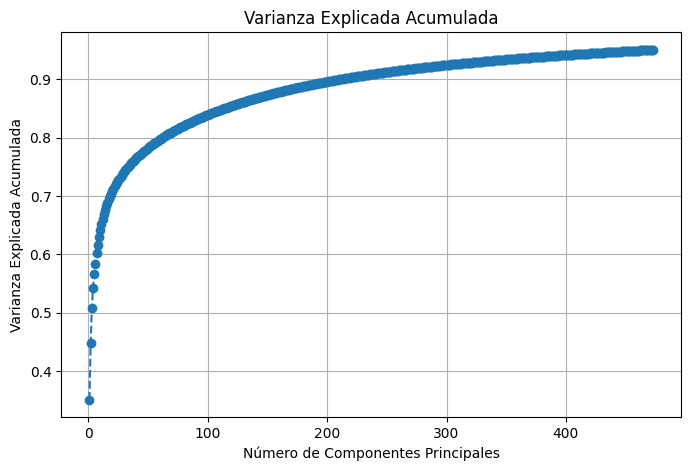

In [20]:
reload(utils)
from utils import preprocess_and_pca

cols_close = [col for col in train.columns if "Close" in col ]+ ['Date']
cols_adjusted = [col for col in cols_close if "Adjusted" in col]

# Separar características y etiquetas
X_train = train.drop(columns=cols_close)  # Eliminar todas las columnas que contienen "Close"
X_test = test.drop(columns=cols_close)


# Para y_train y y_test, nos  con "AdjustedClose" y "Date"
y_train = train[cols_adjusted]
y_test = test[cols_adjusted]


# Aplicar la función con tus datos
X_train_pca, X_test, varianza_acumulada = preprocess_and_pca(X_train, X_test)


In [24]:
display(y_train)

display(y_test)
historic_prices=pd.concat([y_train,y_test],axis=0,ignore_index=True)
display(historic_prices.shape)
historic_prices.to_csv('historic_prices.csv')


sys=DummyRegressor(strategy='mean')
sys.fit(X_train_pca,y_train)
preds=sys.predict(X_test)
display(X_test)
display(preds.shape)
display(type(preds))

preds_df=pd.DataFrame(preds)
display(preds_df)
preds_df.to_csv('predicciones_dummy.csv')

,AdjustedClose_A,AdjustedClose_AAL,AdjustedClose_AAP,AdjustedClose_AAPL,AdjustedClose_ABBV,AdjustedClose_ABT,AdjustedClose_ACGL,AdjustedClose_ACN,AdjustedClose_ADBE,AdjustedClose_ADI,...,AdjustedClose_WYNN,AdjustedClose_XEL,AdjustedClose_XOM,AdjustedClose_XRAY,AdjustedClose_XYL,AdjustedClose_YUM,AdjustedClose_ZBH,AdjustedClose_ZBRA,AdjustedClose_ZION,AdjustedClose_ZTS
0,20.053032,4.496876,35.743465,6.447411,21.629181,18.763710,7.601905,31.941786,37.090000,22.258951,...,41.184948,12.678841,39.272129,31.206663,20.299332,18.878279,52.354065,28.670000,10.223137,28.409882
1,19.835201,5.005958,35.531013,6.458559,21.629181,18.612122,7.576549,32.139191,37.700001,22.223808,...,43.689789,12.528476,39.425449,30.835669,20.299332,18.813721,54.011391,28.620001,10.583591,28.409882
2,19.764729,4.798555,35.840828,6.355825,21.629181,18.715475,7.543795,32.480869,37.619999,22.181643,...,43.116714,12.552535,39.766201,31.038830,20.299332,18.679226,53.993958,28.400000,11.503902,28.409882
3,19.739101,4.939965,35.831978,6.344078,21.629181,18.870523,7.499420,32.450485,36.889999,22.005934,...,44.037506,12.498397,39.641258,31.445143,20.299332,18.673838,55.232574,27.690001,12.792341,28.409882
4,19.732687,4.845691,35.973618,6.386254,21.629181,18.966999,7.484628,32.321415,36.689999,22.132442,...,43.721996,12.504411,39.482250,31.445143,20.299332,18.679226,54.072460,27.600000,12.585275,28.409882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3611,138.629974,14.310000,60.152214,192.656174,149.475891,106.896759,70.214340,348.842224,598.750000,193.812241,...,89.438622,59.755745,98.548370,34.478691,111.410484,127.463387,119.562088,269.410004,42.445381,193.067841
3612,138.868347,14.110000,59.828129,192.108871,149.167191,107.092850,69.900551,347.838379,598.260010,195.552704,...,90.012337,59.938690,98.770782,34.791958,112.379784,127.718323,120.655167,275.500000,43.294289,193.582718
3613,138.878296,13.990000,60.456661,192.208359,149.417999,107.641884,69.929077,348.222168,596.080017,196.024704,...,89.646355,59.754200,98.306625,34.880062,113.131493,128.286987,120.366989,275.790009,42.937355,194.968994
3614,138.828629,13.980000,60.387917,192.636276,149.292603,108.239960,70.423546,346.027466,595.520020,196.899872,...,90.764099,60.094044,96.885117,34.978340,113.072144,127.973251,120.863838,275.350006,43.082058,195.226456


,AdjustedClose_A,AdjustedClose_AAL,AdjustedClose_AAP,AdjustedClose_AAPL,AdjustedClose_ABBV,AdjustedClose_ABT,AdjustedClose_ACGL,AdjustedClose_ACN,AdjustedClose_ADBE,AdjustedClose_ADI,...,AdjustedClose_WYNN,AdjustedClose_XEL,AdjustedClose_XOM,AdjustedClose_XRAY,AdjustedClose_XYL,AdjustedClose_YUM,AdjustedClose_ZBH,AdjustedClose_ZBRA,AdjustedClose_ZION,AdjustedClose_ZTS
0,138.048584,13.44,60.839672,184.734985,154.183792,107.700714,71.840385,341.431366,580.070007,190.350952,...,93.573265,61.628197,98.983528,35.017651,112.429237,126.512314,120.625351,267.980011,42.580433,194.642227
1,130.496964,12.95,59.906696,183.351761,154.801224,107.377167,73.162132,332.573730,571.789978,185.808044,...,93.009445,61.735008,99.815163,34.221577,110.342270,126.580956,119.711151,252.520004,40.516045,191.037918
2,130.337784,13.09,59.405842,181.023178,155.765961,108.808601,73.666107,331.756866,567.049988,182.966232,...,93.187492,61.880653,98.944847,35.066795,111.103867,126.178955,119.442841,252.970001,41.133430,192.137054
3,129.899979,13.60,60.417381,180.296707,156.421967,108.632126,73.038513,331.294312,564.599976,183.438217,...,94.611870,61.880653,99.244621,34.771950,110.925835,125.835777,119.224236,252.690002,42.493610,192.939117
4,132.705734,14.58,60.800385,184.655365,155.737015,110.200813,73.333298,334.965332,580.549988,185.827698,...,95.996674,61.735008,97.591034,35.283012,111.618187,126.129936,121.201706,261.089996,42.966301,194.226349
5,130.019363,14.38,60.289703,184.237411,156.585983,110.524361,72.410927,337.327332,586.200012,186.594666,...,94.226097,61.434002,96.382263,35.902184,110.886269,125.718124,121.102341,256.440002,42.483967,194.018402
6,130.427307,14.35,59.887058,185.282303,159.074982,112.161690,73.181152,339.866486,591.030029,185.227859,...,92.613777,60.899960,95.434593,36.747402,111.014839,126.679001,122.453773,255.270004,42.377853,196.820679
7,129.024429,14.59,61.563461,184.685196,158.004135,111.816887,73.808746,342.464722,597.489990,185.808044,...,92.880859,59.229870,95.415245,35.823559,110.451073,126.482903,121.609116,255.029999,41.808697,194.780869
8,129.880066,13.21,60.449146,185.013596,158.169708,112.230652,73.875305,350.692444,596.539978,185.218033,...,93.088570,59.530880,96.653023,35.931667,110.510414,126.610374,122.294769,248.869995,40.622158,196.988998
9,129.870132,13.19,60.547760,182.734787,157.273666,112.073021,74.331734,348.950470,597.679993,184.657532,...,93.533691,59.142483,94.467583,35.332153,109.748817,127.277100,121.867485,243.520004,39.705719,191.097366


(3637, 500)

array([[ 1.75005242,  1.75740624,  1.72655083, ..., -1.61078119,
         1.86025205, -0.70525103],
       [ 1.6878497 ,  1.58950324,  1.72194064, ..., -1.61078119,
         1.86025205,  0.00352822],
       [ 1.53174227,  1.56790155,  1.54117521, ..., -1.61078119,
         1.86025205,  0.71230746],
       ...,
       [ 1.59730729,  1.57894773,  1.61784899, ..., -1.61078119,
         1.86025205,  1.42108671],
       [ 1.56536527,  1.59465795,  1.57029173, ..., -1.61078119,
         1.86025205, -1.41403028],
       [ 1.60427229,  1.62926964,  1.5964967 , ..., -1.61078119,
         1.86025205, -0.70525103]])

(21, 500)

numpy.ndarray

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,64.273168,24.464557,115.136796,57.670481,60.939588,55.750927,27.705658,138.736347,205.964436,78.381387,...,102.141455,36.933363,58.258436,43.123386,54.487089,67.480185,97.213288,159.536612,29.890582,81.599657
1,64.273168,24.464557,115.136796,57.670481,60.939588,55.750927,27.705658,138.736347,205.964436,78.381387,...,102.141455,36.933363,58.258436,43.123386,54.487089,67.480185,97.213288,159.536612,29.890582,81.599657
2,64.273168,24.464557,115.136796,57.670481,60.939588,55.750927,27.705658,138.736347,205.964436,78.381387,...,102.141455,36.933363,58.258436,43.123386,54.487089,67.480185,97.213288,159.536612,29.890582,81.599657
3,64.273168,24.464557,115.136796,57.670481,60.939588,55.750927,27.705658,138.736347,205.964436,78.381387,...,102.141455,36.933363,58.258436,43.123386,54.487089,67.480185,97.213288,159.536612,29.890582,81.599657
4,64.273168,24.464557,115.136796,57.670481,60.939588,55.750927,27.705658,138.736347,205.964436,78.381387,...,102.141455,36.933363,58.258436,43.123386,54.487089,67.480185,97.213288,159.536612,29.890582,81.599657
5,64.273168,24.464557,115.136796,57.670481,60.939588,55.750927,27.705658,138.736347,205.964436,78.381387,...,102.141455,36.933363,58.258436,43.123386,54.487089,67.480185,97.213288,159.536612,29.890582,81.599657
6,64.273168,24.464557,115.136796,57.670481,60.939588,55.750927,27.705658,138.736347,205.964436,78.381387,...,102.141455,36.933363,58.258436,43.123386,54.487089,67.480185,97.213288,159.536612,29.890582,81.599657
7,64.273168,24.464557,115.136796,57.670481,60.939588,55.750927,27.705658,138.736347,205.964436,78.381387,...,102.141455,36.933363,58.258436,43.123386,54.487089,67.480185,97.213288,159.536612,29.890582,81.599657
8,64.273168,24.464557,115.136796,57.670481,60.939588,55.750927,27.705658,138.736347,205.964436,78.381387,...,102.141455,36.933363,58.258436,43.123386,54.487089,67.480185,97.213288,159.536612,29.890582,81.599657
9,64.273168,24.464557,115.136796,57.670481,60.939588,55.750927,27.705658,138.736347,205.964436,78.381387,...,102.141455,36.933363,58.258436,43.123386,54.487089,67.480185,97.213288,159.536612,29.890582,81.599657


## Forecasting Model 

### **Model Selection**

In [ ]:




metrics={
    'MSE':[]
    ,'MAE':[] 
    ,'RMSE':[]
    ,'R2':[]
    ,'MAPE':[]
}
scoring = {
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'RMSE': make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False),
    'R2': make_scorer(r2_score),
    'MAPE': make_scorer(mean_absolute_percentage_error, greater_is_better=False)
}
models = {
    'DummyRegressor': MultiOutputRegressor(DummyRegressor()),  # Baseline sin ningún ajuste
    'Poisson': MultiOutputRegressor(PoissonRegressor(alpha=1.0, max_iter=100)),  # Aumentamos alpha y limitamos el número de iteraciones
    'Tweedie': MultiOutputRegressor(TweedieRegressor(alpha=1.0, max_iter=100)),  # Aumentamos alpha y limitamos el número de iteraciones
    'Ridge': MultiOutputRegressor(Ridge(alpha=1.0)),  # Establecemos alpha para controlar la regularización
    'Lasso': MultiOutputRegressor(Lasso(alpha=0.1)),  # Establecemos alpha para limitar la complejidad
    'ElasticNet': MultiOutputRegressor(ElasticNet(alpha=0.1, l1_ratio=0.5)),  # Reducimos alpha y ajustamos l1_ratio
    'BayesianRidge': MultiOutputRegressor(BayesianRidge()),  # Sin cambios (modelo simple por defecto)
    'ARDRegression': MultiOutputRegressor(ARDRegression(alpha_1=1e-6, alpha_2=1e-6)),  # Aumentamos los valores de alpha para mayor regularización
    'Huber': MultiOutputRegressor(HuberRegressor(alpha=0.1)),  # Establecemos alpha para controlar la regularización
    'PassiveAggressive': MultiOutputRegressor(PassiveAggressiveRegressor(C=0.5, max_iter=100)),  # Reducimos C y limitamos el número de iteraciones
    'KNN': MultiOutputRegressor(KNeighborsRegressor(n_neighbors=45, n_jobs=1)),  # Reducimos el número de vecinos
    'LinearRegression': MultiOutputRegressor(LinearRegression(n_jobs=1)),  # Sin cambios (es un modelo simple por defecto)
    'DecisionTree': MultiOutputRegressor(DecisionTreeRegressor(max_depth=4)),  # Reducimos la profundidad máxima
    'SVR': MultiOutputRegressor(SVR(C=0.5)),  # Reducimos el valor de C para limitar la complejidad
    'GaussianProcess': MultiOutputRegressor(GaussianProcessRegressor(alpha=1e-1)),  # Aumentamos alpha para agregar regularización
    'ExtraTrees': MultiOutputRegressor(ExtraTreesRegressor(n_jobs=1, max_depth=4, n_estimators=50)),  # Reducimos la profundidad máxima y el número de estimadores
    'Bagging': MultiOutputRegressor(BaggingRegressor(n_jobs=1, n_estimators=20)),  # Reducimos el número de estimadores
    'TheilSen': MultiOutputRegressor(TheilSenRegressor(n_jobs=1, max_subpopulation=1000)),  # Limitamos el tamaño de la subpoblación
    'CatBoost': CatBoostRegressor(thread_count=1, loss_function='MultiRMSE', depth=4, iterations=50),  # Reducimos la profundidad y el número de iteraciones
    'XGBoost': XGBRegressor(n_jobs=1, objective='reg:squarederror', max_depth=4, n_estimators=50),  # Reducimos la profundidad y el número de estimadores
    'LightGBM': MultiOutputRegressor(LGBMRegressor(n_jobs=1, objective='regression_l2')),  # Adaptar para multisalida
    'HistGradientBoosting': MultiOutputRegressor(HistGradientBoostingRegressor(max_iter=50, max_depth=4)),  # Reducimos el número de iteraciones y la profundidad
    'RandomForest': MultiOutputRegressor(RandomForestRegressor(n_jobs=1, max_depth=5, n_estimators=50)),  # Reducimos la profundidad máxima y el número de estimadores
    'GradientBoosting': MultiOutputRegressor(GradientBoostingRegressor(max_depth=5, n_estimators=50)),  # Reducimos la profundidad máxima y el número de estimadores
    'AdaBoost': MultiOutputRegressor(AdaBoostRegressor(n_estimators=50)),  # Reducimos el número de estimadores

}





metrics_df = pd.DataFrame(columns=metrics, index=models.keys())

abbreviations = {
    'DummyRegressor': 'Dummy',
    'RandomForest': 'RF',
    'GradientBoosting': 'GB',
    'AdaBoost': 'AB',
    'KNN': 'KNN',
    'LinearRegression': 'LR',
    'DecisionTree': 'DT',
    'SVR': 'SVR',
    'GaussianProcess': 'GP',
    'ExtraTrees': 'ET',
    'Bagging': 'Bag',
    'Ridge': 'Ridge',
    'Lasso': 'Lasso',
    'ElasticNet': 'EN',
    'BayesianRidge': 'BR',
    'ARDRegression': 'ARD',
    'Huber': 'Huber',
    'PassiveAggressive': 'PA',
    'TheilSen': 'TS',
    'CatBoost': 'Cat',
    'XGBoost': 'XGB',
    'LightGBM': 'LGBM',
    'HistGradientBoosting': 'HGB',
    'Poisson': 'Poi',
    'Tweedie': 'Twee'
}



execution_times = pd.DataFrame(columns=["Model", "Execution_Time"])

# Crear un TimeSeriesSplit con 5 splits
tscv = TimeSeriesSplit(n_splits=25)

# Para cada modelo en la lista
for name, model in models.items():
    # print(f"Training {name} ...")
    
    # Inicializar listas para promediar métricas en cada fold
    mse_list, rmse_list, mae_list, r2_list, mape_list = [], [], [], [], []
    start_time = time.time()

   # Obtener param_grid para el modelo actual
    # param_grid = param_grids.get(name, {})
    param_grid=False
    
    # Si hay hiperparámetros para ajustar, usar RandomizedSearchCV
    if param_grid:
        search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_grid,
            n_iter=20,
            cv=5,
            scoring=scoring,
            refit='RMSE',
            n_jobs=-1,
            verbose=1,
            random_state=42
        )
        search.fit(X_train, y_train)
        best_model = search.best_estimator_
        print(f"Best Parameters for {name}:", search.best_params_)
    else:
        # Si no hay parámetros, usar el modelo original
        best_model = model
    
    # Inicializar listas para métricas por fold
    mse_list, rmse_list, mae_list, r2_list, mape_list = [], [], [], [], []
    
    # Entrenar y evaluar el modelo con los mejores parámetros en cada fold
    split_counter = 1
    total_splits = tscv.get_n_splits(X_train)
    for train_index, val_index in tscv.split(X_train):
        progress_percentage = (split_counter / total_splits) * 100
        
        # Dividir los datos según los índices
        X_train_fold = X_train.iloc[train_index]
        X_val_fold = X_train.iloc[val_index]
        y_train_fold = y_train.iloc[train_index]
        y_val_fold = y_train.iloc[val_index]
        
        X_train = X_train.loc[:, ~X_train.columns.str.contains('^Unnamed')]

        # Entrenar el modelo optimizado en el fold actual
        best_model.fit(X_train_fold, y_train_fold)
        
        # Predecir en el conjunto de validación
        predictions = best_model.predict(X_val_fold)
        
        # Calcular métricas para este fold
        mse = mean_squared_error(y_val_fold, predictions)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_val_fold, predictions)
        r2 = r2_score(y_val_fold, predictions)
        mape = mean_absolute_percentage_error(y_val_fold, predictions)
        
        # Guardar métricas del fold
        mse_list.append(mse)
        rmse_list.append(rmse)
        mae_list.append(mae)
        r2_list.append(r2)
        mape_list.append(mape)
        
        split_counter += 1
    
    # Promediar las métricas sobre todos los folds y guardarlas
    metrics_df.loc[name] = [
        np.mean(mse_list),
        np.mean(rmse_list),
        np.mean(mae_list),
        np.mean(r2_list),
        np.mean(mape_list)
    ]
    
    # Registrar tiempo de fin
    end_time = time.time()
    execution_time = end_time - start_time
    new_row = pd.DataFrame({"Model": [name], "Execution_Time": [execution_time]})
    execution_times = pd.concat([execution_times, new_row], ignore_index=True)

execution_times.set_index("Model", inplace=True)
display(execution_times)
# Cambiar nombres en el índice del DataFrame
display(metrics_df.sort_values(by=['RMSE','MAPE'],ascending=True))
metrics_df_sorted = metrics_df.sort_values(by='RMSE', ascending=True)

metrics_df.rename(index=abbreviations, inplace=True)

# Crear una figura con subplots organizados en una cuadrícula
fig, axes = plt.subplots(3, 2, figsize=(20, 15))  # Ajustar el tamaño según las necesidades
axes = axes.flatten()  # Aplanar los ejes para facilitar la iteración
fig.suptitle('Forecasting Metrics for All Models (Logarithmic Scale)', fontsize=16)

# Iterar sobre las métricas para graficar en cada subplot
for i, metric in enumerate(metrics_df.columns):
    ax = axes[i]  # Seleccionar el subplot correspondiente
    
    # Ordenar métricas de forma ascendente
    sorted_metric = metrics_df[metric].sort_values(ascending=True)
    
    # Graficar métricas como barras con escala logarítmica
    ax.bar(sorted_metric.index, sorted_metric, color='skyblue')
    ax.set_xlabel('Models', fontsize=12)
    ax.set_ylabel(metric, fontsize=12)
    ax.set_title(f'Comparison of {metric} (Log Scale)', fontsize=14)
    ax.tick_params(axis='x', rotation=45)  # Rotar etiquetas del eje X
    ax.set_yscale('log')  # Aplicar escala logarítmica
    ax.grid(True, linestyle='--', alpha=0.6)  # Agregar líneas de cuadrícula

# Eliminar subplots vacíos si hay más subplots que métricas
for j in range(len(metrics_df.columns), len(axes)):
    fig.delaxes(axes[j])  # Eliminar ejes innecesarios

# Ajustar diseño y guardar la figura
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Ajustar espacio para el título general
plt.savefig('plots/metrics_comparison_log_scale.png')
plt.show()




C:\Users\user\AppData\Local\Temp\ipykernel_30316\2615889880.py:310: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  execution_times = pd.concat([execution_times, new_row], ignore_index=True)
c:\Users\user\OneDrive - Universidad de Oviedo\Escritorio\UNI\3ºAÑO\LAB_IACD\Proyecto_2_Lab_IACD\.venv\Lib\site-packages\sklearn\linear_model\_glm\glm.py:283: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
c:\Users\user\OneDrive - Universidad de Oviedo\Escritorio\UNI\3ºAÑO\LAB_IACD\Proyecto_2_Lab_IACD\.venv

KeyboardInterrupt: 

### **Evolution of PCA**

In [25]:
# Cargar datos
# train = pd.read_csv('train.csv')
# test = pd.read_csv('test.csv')

# Identificar columnas objetivo
# Identificar las columnas que contienen "Close" (todas)
cols_close = [col for col in train.columns if "Close" in col ]+ ['Date']

# Identificar las columnas que contienen "AdjustedClose"
cols_adjusted = [col for col in cols_close if "Adjusted" in col]

# Separar características y etiquetas
X_train = train.drop(columns=cols_close)  # Eliminar todas las columnas que contienen "Close"
X_test = test.drop(columns=cols_close)
# Limitar X_test para coincidir con y_test
X_test =X_test.iloc[0:4, :]


# Para y_train y y_test, quedarnos con "AdjustedClose" y "Date"
y_train = train[cols_adjusted]
y_test = test[cols_adjusted]
y_test =y_test.iloc[0:4, :]
# y_test=y_test.to_frame()
# y_test=y_test.T
display(y_test)
print(type(X_train))


# Listas de componentes y modelos
list_componentes = [10,20,30,40,50,100,150,200, 473]
# list_componentes = [comp for comp in range(1,11)]
models = {
    'Bagging': MultiOutputRegressor(BaggingRegressor(n_jobs=1, n_estimators=20)),
    'XGBoost': XGBRegressor(n_jobs=1, objective='reg:squarederror', max_depth=4, n_estimators=50),
    'LightGBM': MultiOutputRegressor(LGBMRegressor(n_jobs=1, objective='regression_l2')),
}

metrics = ['RMSE', 'R2', 'MAPE','MPE']
all_metrics_df = {metric: pd.DataFrame(index=models.keys(), columns=[str(c) for c in list_componentes]) for metric in metrics}

# Crear carpeta para guardar gráficos
os.makedirs('plots', exist_ok=True)

# Evaluar modelos con diferentes componentes de PCA
for n_components in list_componentes:
    print(f"Evaluando PCA con {n_components} componentes...")

    # Aplicar Incremental PCA
    ipca = IncrementalPCA(n_components=n_components)
    X_train_pca = ipca.fit_transform(X_train)
    X_test_pca = ipca.transform(X_test)

    # Evaluar modelos
    metrics_df = pd.DataFrame(index=models.keys(), columns=metrics)
    for name, model in models.items():
        print(f"Entrenando modelo: {name} con {n_components} componentes.")
        model.fit(X_train_pca, y_train)
        predictions = model.predict(X_test_pca)

        # Calcular métricas
        mse = mean_squared_error(y_test, predictions)
        rmse = np.sqrt(mse)
        # mae = mean_absolute_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)
        mape = mean_absolute_percentage_error(y_test, predictions)
        mpe= mean_positive_error(y_test,predictions)
        
        metrics_df.loc[name] = [rmse,r2, mape, mpe]

    # Guardar métricas en el DataFrame general
    for metric in metrics:
        all_metrics_df[metric][str(n_components)] = metrics_df[metric]

fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten() 
fig.suptitle('Forecasting Metrics While Increasing the Number of Components 4-day Forecast', fontsize=16)
# Graficar resultados
# Graficar resultados en cada eje
for i, metric in enumerate(metrics):  # Enumerar para acceder a los ejes correspondientes
    ax = axes[i]  # Seleccionar el eje correspondiente
    for model in models.keys():
        ax.plot(list_componentes, 
                all_metrics_df[metric].loc[model].astype(float), 
                marker='o', 
                label=model)
    
    ax.set_xlabel('Number of Components (PCA)', fontsize=12)
    ax.set_ylabel(metric, fontsize=12)
    ax.set_title(f'Comparison of {metric}', fontsize=14)
    ax.legend(title='Models', loc='upper right')
    ax.grid(True)

# Ajustar el diseño y ocultar cualquier subplot vacío
for j in range(len(metrics), len(axes)):  # Si hay más ejes que métricas
    fig.delaxes(axes[j])  # Eliminar los ejes innecesarios

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Ajustar espacio para el título general
plt.savefig('plots/metrics_comparison_pca_comp.png')
plt.show()





,AdjustedClose_A,AdjustedClose_AAL,AdjustedClose_AAP,AdjustedClose_AAPL,AdjustedClose_ABBV,AdjustedClose_ABT,AdjustedClose_ACGL,AdjustedClose_ACN,AdjustedClose_ADBE,AdjustedClose_ADI,...,AdjustedClose_WYNN,AdjustedClose_XEL,AdjustedClose_XOM,AdjustedClose_XRAY,AdjustedClose_XYL,AdjustedClose_YUM,AdjustedClose_ZBH,AdjustedClose_ZBRA,AdjustedClose_ZION,AdjustedClose_ZTS
3616,138.048569,13.44,60.839672,184.734985,154.183792,107.700714,71.840385,341.431335,580.070007,191.156937,...,93.573257,61.628197,98.983528,35.017651,112.744011,127.125343,120.625359,267.980011,42.580433,194.642258
3617,130.496964,12.95,59.906696,183.351761,154.801224,107.377167,73.162132,332.573761,571.789978,186.594772,...,93.009453,61.735004,99.815155,34.221573,110.651207,127.194328,119.711151,252.520004,40.516045,191.037918
3618,130.337769,13.09,59.405838,181.023163,155.765945,108.808601,73.666107,331.756897,567.049988,183.740936,...,93.187492,61.880650,98.944847,35.066792,111.414932,126.790359,119.442848,252.970001,41.133430,192.137054
3619,129.899979,13.60,60.417377,180.296707,156.421982,108.632126,73.038513,331.294281,564.599976,184.214935,...,94.611870,61.880650,99.244621,34.771950,111.236412,126.445534,119.224243,252.690002,42.493614,192.939102


<class 'pandas.core.frame.DataFrame'>
Evaluando PCA con 10 componentes...
Entrenando modelo: Bagging con 10 componentes.
Entrenando modelo: XGBoost con 10 componentes.
Entrenando modelo: LightGBM con 10 componentes.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,000569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 3616, number of used features: 10
[LightGBM] [Info] Start training from score 64,273169
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,000422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 3616, number of used features: 10
[LightGBM] [Info] Start training from score 24,464557
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,000137 secon

KeyboardInterrupt: 

### **Evolution of number of forecasting days**

20


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

Evaluando modelos para 0 días...
Ventana vacía para 0 días. Saltando...
Evaluando modelos para 1 días...


c:\Users\user\OneDrive - Universidad de Oviedo\Escritorio\UNI\3ºAÑO\LAB_IACD\Proyecto_2_Lab_IACD\.venv\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\user\OneDrive - Universidad de Oviedo\Escritorio\UNI\3ºAÑO\LAB_IACD\Proyecto_2_Lab_IACD\.venv\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\user\OneDrive - Universidad de Oviedo\Escritorio\UNI\3ºAÑO\LAB_IACD\Proyecto_2_Lab_IACD\.venv\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 3522, number of used features: 8
[LightGBM] [Info] Start training from score 64.241936
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 3522, number of used features: 8
[LightGBM] [Info] Start training from score 24.478717
Evaluando modelos para 2 días...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 3522, number of used features: 

,0,1,2,3,4,5,6,7,8,9,...,10,11,12,13,14,15,16,17,18,19
Bagging,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.116934,3.645657,4.026132,3.246022,3.427823,3.482308,3.142443,3.346563,3.96214,2.796507
XGBoost,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.668702,4.727322,4.645324,4.502353,4.356869,4.315982,4.358435,4.330405,4.343979,4.272724
LightGBM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.615008,3.740312,3.583931,3.443985,3.467888,3.366624,3.264774,3.193164,3.123047,3.047873


,0,1,2,3,4,5,6,7,8,9,...,10,11,12,13,14,15,16,17,18,19
Bagging,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.0093,-1.576072,-7.817894,-1.35972,-2.156137,-2.106252,-2.132199,-1.951324,-3.080388,-1.269726
XGBoost,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-7.698388,-7.106119,-7.278038,-7.430531,-7.516815,-7.612248,-7.796693,-6.102967,-5.725851,-5.402166
LightGBM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.88315,-2.198756,-2.174506,-2.183829,-2.337988,-2.410833,-2.382468,-2.23055,-2.222768,-2.060818


,0,1,2,3,4,5,6,7,8,9,...,10,11,12,13,14,15,16,17,18,19
Bagging,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.033268,0.040616,0.081157,0.031889,0.040806,0.037314,0.037392,0.036151,0.043037,0.033002
XGBoost,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.085911,0.086253,0.082877,0.080013,0.077608,0.075123,0.073497,0.072212,0.070313,0.067932
LightGBM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.039992,0.045903,0.04242,0.040037,0.039201,0.039094,0.038384,0.040613,0.042089,0.041037


,0,1,2,3,4,5,6,7,8,9,...,10,11,12,13,14,15,16,17,18,19
Bagging,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.267407,1.746747,2.234978,1.216108,0.847366,1.404251,1.215118,1.517059,2.258948,0.80279
XGBoost,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.868418,3.01102,3.001611,2.917638,2.812487,2.817315,2.878469,2.867021,2.886864,2.834456
LightGBM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.750619,1.98018,1.815165,1.686853,1.574306,1.469352,1.401286,1.339293,1.288194,1.220394


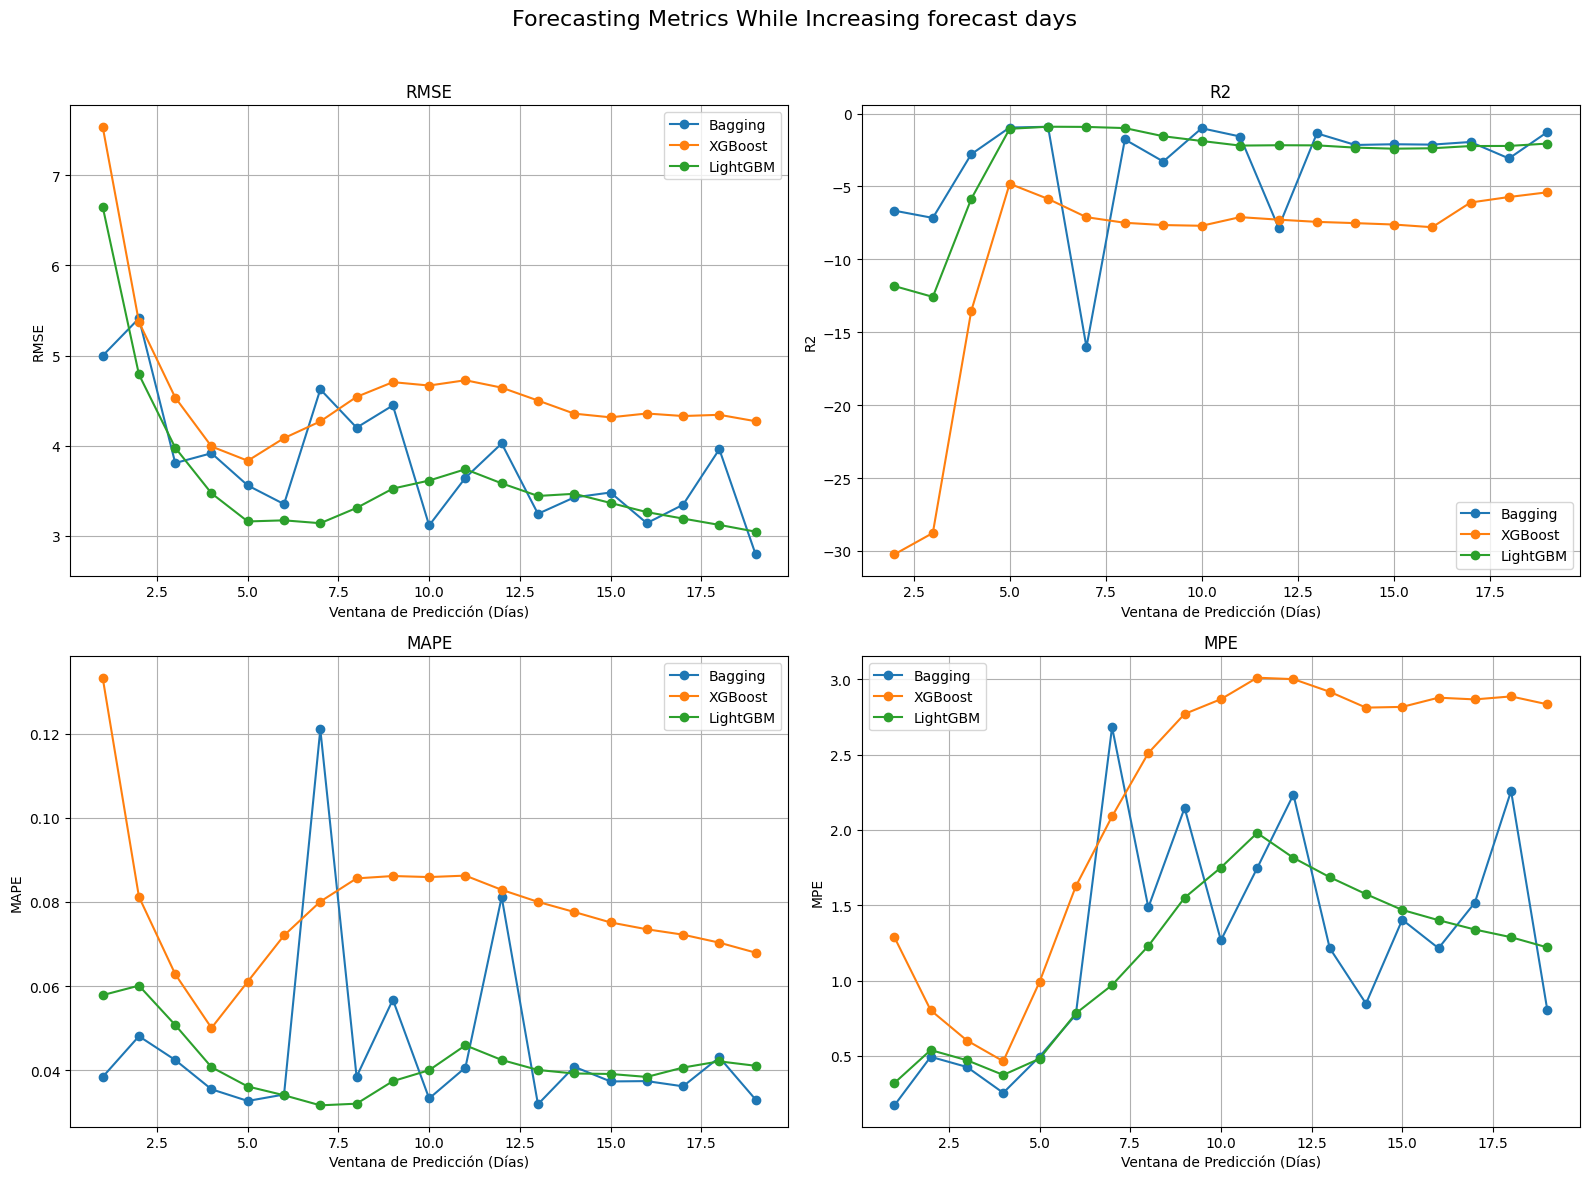

<Figure size 640x480 with 0 Axes>

In [4]:
train=pd.read_csv('train_pequeño.csv')
test=pd.read_csv('test_pequeño.csv')

cols_close = [col for col in train.columns if "Close" in col ]+ ['Date']
cols_adjusted = [col for col in cols_close if "Adjusted" in col]

# Separar características y etiquetas
X_train = train.drop(columns=cols_close)  # Eliminar todas las columnas que contienen "Close"
X_test = test.drop(columns=cols_close)


number_days_original=X_test.shape[0]
print(number_days_original)
# Para y_train y y_test, quedarnos con "AdjustedClose" y "Date"
y_train = train[cols_adjusted]
y_test = test[cols_adjusted]



list_componentes=[day for day in range(0,number_days_original)]
display(list_componentes)
models = {
    'Bagging': MultiOutputRegressor(BaggingRegressor(n_jobs=1)),
    'XGBoost': XGBRegressor(n_jobs=1, objective='reg:squarederror'),
    'LightGBM': MultiOutputRegressor(LGBMRegressor(n_jobs=1, objective='regression_l2')),
}

metrics = ['RMSE', 'R2', 'MAPE','MPE']
all_metrics_df = {metric: pd.DataFrame(index=models.keys(), columns=[str(c) for c in list_componentes]) for metric in metrics}
X_train = X_train.loc[:, ~X_train.columns.str.contains('^Unnamed')]
X_test = X_test.loc[:, ~X_test.columns.str.contains('^Unnamed')]
# Evaluar modelos con diferentes componentes de PCA
for n_components in list_componentes:
    
    
    print(f"Evaluando modelos para {n_components} días...")

    # # Validar índice
    # if n_components >= X_test.shape[0] or n_components >= y_test.shape[0]:
    #     print(f"Saltando n_components={n_components}: fuera de rango.")
    #     continue

    # Seleccionar ventana
    X_test_window = X_test.iloc[0:n_components, :].copy()
    y_test_window = y_test.iloc[0:n_components, :].copy()

    # Verificar subconjuntos no vacíos
    if X_test_window.empty or y_test_window.empty:
        print(f"Ventana vacía para {n_components} días. Saltando...")
        continue

    # Aplicar PCA
    n_pca_components = min(8, X_train.shape[1])
    ipca = IncrementalPCA(n_components=n_pca_components)
    X_train_pca = ipca.fit_transform(X_train)
    X_test_pca = ipca.transform(X_test_window)


    # Evaluar modelos
    metrics_df = pd.DataFrame(index=models.keys(), columns=metrics)
    for name, model in models.items():
        model.fit(X_train_pca, y_train)
        predictions = model.predict(X_test_pca)

        # Calcular métricas
        mse = mean_squared_error(y_test_window, predictions)
        rmse = np.sqrt(mse)
        # mae = mean_absolute_error(y_test, predictions)
        r2   = r2_score(y_test_window, predictions)
        mape = mean_absolute_percentage_error(y_test_window, predictions)
        mpe  = mean_positive_error(y_test_window,predictions)
        
        metrics_df.loc[name] = [rmse,r2, mape, mpe]

    # Guardar métricas en el DataFrame general
    for metric in metrics:
        all_metrics_df[metric][n_components] = metrics_df[metric]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten() 
fig.suptitle('Forecasting Metrics While Increasing forecast days', fontsize=16)
# Graficar resultados


for i, metric in enumerate(metrics):
    ax = axes[i]
    display(all_metrics_df[metric])
    for model in models.keys():
        ax.plot(all_metrics_df[metric].columns.astype(int),
                all_metrics_df[metric].loc[model].astype(float),
                marker='o', label=model)
    ax.set_title(metric)
    ax.set_xlabel('Ventana de Predicción (Días)')
    ax.set_ylabel(metric)
    ax.legend()
    ax.grid()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Ajustar el diseño y ocultar cualquier subplot vacío
for j in range(len(metrics), len(axes)):  # Si hay más ejes que métricas
    fig.delaxes(axes[j])  # Eliminar los ejes innecesarios

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Ajustar espacio para el título general
plt.savefig('plots/metrics_comparison_days_comp.png')
plt.show()





# **Final prediction**

In [ ]:
cols_close = [col for col in train.columns if "Close" in col ]+ ['Date']
cols_adjusted = [col for col in cols_close if "Adjusted" in col]

# Separar características y etiquetas
X_train = train.drop(columns=cols_close)  # Eliminar todas las columnas que contienen "Close"
X_test = test.drop(columns=cols_close)


number_days_original=X_test.shape[0]
# Para y_train y y_test, quedarnos con "AdjustedClose" y "Date"
y_train = train[cols_adjusted]
y_test = test[cols_adjusted]

ipca = IncrementalPCA(n_components=473)
X_train = ipca.fit_transform(X_train)
X_test = ipca.transform(X_test)

tscv = TimeSeriesSplit(n_splits=25)

param_grids = {
    'DummyRegressor': {},
    
    'RandomForest': {
        'estimator__n_estimators': [50, 100, 200],
        'estimator__max_depth': [3, 5, 7, None],
        'estimator__min_samples_split': [2, 5, 10]
    },
    
    'GradientBoosting': {
        'estimator__n_estimators': [50, 100, 200],
        'estimator__max_depth': [3, 5, 7],
        'estimator__learning_rate': [0.01, 0.05, 0.1],
        'estimator__subsample': [1.0, 0.8, 0.6]
    },
    
    'AdaBoost': {
        'estimator__n_estimators': [50, 100, 200],
        'estimator__learning_rate': [0.01, 0.1, 0.5]
    },
    
    'KNN': {
        'estimator__n_neighbors': [5, 15, 45],
        'estimator__weights': ['uniform', 'distance'],
        'estimator__p': [1, 2]  # distancia Manhattan o Euclídea
    },
    
    'LinearRegression': {
        # Normalmente no hay mucho que tunear, pero puedes probar:
        'estimator__fit_intercept': [True, False]
    },
    
    'DecisionTree': {
        'estimator__max_depth': [3, 5, 7, None],
        'estimator__min_samples_split': [2, 5, 10]
    },
    
    'SVR': {
        'estimator__C': [0.1, 1, 10],
        'estimator__epsilon': [0.01, 0.1, 0.5],
        'estimator__kernel': ['rbf', 'linear']
    },
    
    'GaussianProcess': {
        # Ajustar la regularización:
        'estimator__alpha': [1e-2, 1e-1, 1],
        # Si fuese posible ajustar kernel, agregar aquí. Por defecto RBF.
    },
    
    'ExtraTrees': {
        'estimator__n_estimators': [50, 100, 200],
        'estimator__max_depth': [3, 5, 7, None],
        'estimator__min_samples_split': [2, 5, 10]
    },
    
    'Bagging': {
        'estimator__n_estimators': [10, 20, 50],
        'estimator__max_samples': [0.5, 0.8, 1.0],
        'estimator__max_features': [0.5, 0.8, 1.0]
    },
    
    'Ridge': {
        'estimator__alpha': [0.1, 1.0, 10.0]
    },
    
    'Lasso': {
        'estimator__alpha': [0.01, 0.1, 1.0]
    },
    
    'ElasticNet': {
        'estimator__alpha': [0.01, 0.1, 1.0],
        'estimator__l1_ratio': [0.2, 0.5, 0.8]
    },
    
    'BayesianRidge': {
        # Parámetros de regularización:
        'estimator__alpha_1': [1e-7, 1e-6, 1e-5],
        'estimator__alpha_2': [1e-7, 1e-6, 1e-5]
    },
    
    'ARDRegression': {
        'estimator__alpha_1': [1e-7, 1e-6, 1e-5],
        'estimator__alpha_2': [1e-7, 1e-6, 1e-5],
        'estimator__lambda_1': [1e-7, 1e-6, 1e-5],
        'estimator__lambda_2': [1e-7, 1e-6, 1e-5]
    },
    
    'Huber': {
        'estimator__alpha': [0.0001, 0.01, 0.1],
        'estimator__epsilon': [1.1, 1.35, 1.5]
    },
    
    'PassiveAggressive': {
        'estimator__C': [0.1, 0.5, 1.0],
        'estimator__max_iter': [100, 500, 1000]
    },
    
    'TheilSen': {
        'estimator__max_subpopulation': [1000, 5000],
        'estimator__n_subsamples': [None, 50, 100]
    },
    
    'CatBoost': {
        'depth': [3, 4, 6],
        'iterations': [50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [1.0, 0.8]
    },
    
    'XGBoost': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 4, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [1.0, 0.8],
        'colsample_bytree': [1.0, 0.8]
    },
    
    'LightGBM': {
        'estimator__n_estimators': [50, 100, 200],
        'estimator__num_leaves': [31, 63, 127],
        'estimator__learning_rate': [0.01, 0.05, 0.1],
        'estimator__subsample': [1.0, 0.8]
    },
    
    'HistGradientBoosting': {
        'estimator__max_iter': [50, 100, 200],
        'estimator__max_depth': [3, 5, 7],
        'estimator__learning_rate': [0.01, 0.05, 0.1],
        'estimator__l2_regularization': [0.0, 0.1, 1.0]
    },
    
    'Poisson': {
        'estimator__alpha': [0.1, 1.0, 10.0],
        'estimator__max_iter': [100, 300, 500]
    },
    
    'Tweedie': {
        'estimator__alpha': [0.1, 1.0, 10.0],
        'estimator__power': [1.0, 1.5, 2.0],  # Ajustar dependiendo del rango de la variable objetivo
        'estimator__max_iter': [100, 300, 500]
    }
}

if param_grid:
        search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_grid,
            n_iter=20,
            cv=5,
            scoring=scoring,
            refit='RMSE',
            n_jobs=-1,
            verbose=1,
            random_state=42
        )
        search.fit(X_train, y_train)
        best_model = search.best_estimator_
        print(f"Best Parameters for {name}:", search.best_params_)

split_counter = 1
total_splits = tscv.get_n_splits(X_train)
for train_index, val_index in tscv.split(X_train):
    progress_percentage = (split_counter / total_splits) * 100
    
    # Dividir los datos según los índices
    X_train_fold = X_train.iloc[train_index]
    X_val_fold = X_train.iloc[val_index]
    y_train_fold = y_train.iloc[train_index]
    y_val_fold = y_train.iloc[val_index]
    
    X_train = X_train.loc[:, ~X_train.columns.str.contains('^Unnamed')]

    # Entrenar el modelo optimizado en el fold actual
    best_model.fit(X_train_fold, y_train_fold)
    
    # Predecir en el conjunto de validación
    predictions = best_model.predict(X_val_fold)
    
    # Calcular métricas para este fold
    mse = mean_squared_error(y_val_fold, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val_fold, predictions)
    r2 = r2_score(y_val_fold, predictions)
    mape = mean_absolute_percentage_error(y_val_fold, predictions)
    
    # Guardar métricas del fold
    mse_list.append(mse)
    rmse_list.append(rmse)
    mae_list.append(mae)
    r2_list.append(r2)
    mape_list.append(mape)
    
    split_counter += 1

# Promediar las métricas sobre todos los folds y guardarlas
metrics= [
    np.mean(mse_list),
    np.mean(rmse_list),
    np.mean(mae_list),
    np.mean(r2_list),
    np.mean(mape_list)
]

metrics_df_sorted = metrics_df.sort_values(by='RMSE', ascending=True)


best_model.fit(X_train_pca, y_train)
predictions = model.predict(X_test_pca)

predictions_df = pd.DataFrame(predictions,columns=y_train.columns)
predictions_df.to_csv('predicciones_multisalida.csv', index=False)


# **3D Structure**

## **3D Transformation**

In [43]:
############################################################################################################### CÓDIGO DATOS PEQUEÑOS
# Importar y recargar utilidades
reload(utils)
from utils import copy_files

# Configuración de carpetas y parámetros
carpeta_origen = r'data/stocks'
carpeta_destino = r'data/probar'
num_archivos = 50
aleatorio = True

# Copiar archivos
copy_files(carpeta_origen, carpeta_destino, num_archivos, aleatorio)

# Cargar y procesar datos originales
reload(utils)

###############################################################################################################

original_data     = join_stock_data(r"data/probar",axis=True)
original_data['Date'] = pd.to_datetime(original_data['Date']).dt.tz_localize(None)
start = '2010-01-01'
end = '2024-01-31'

macro_data=join_macro(start,end)

raw_data = pd.merge(original_data, macro_data, on='Date', how='inner')
raw_data = raw_data.sort_values(by=[ 'Date']).reset_index(drop=True)
raw_data=raw_data[raw_data['Date'].notna()]



raw_data.bfill( inplace=True)
raw_data.ffill(inplace=True)

df = raw_data
print('Size of Horizontal Structure',raw_data.shape)


# Iterar sobre todas las columnas menos 'Date'
for columna in df.columns:
    if columna not in ['Date'] :
        # Verificar valores no numéricos en la columna
        non_numeric_values = df[columna][~df[columna].apply(lambda x: isinstance(x, (int, float)))]
        # Convertir la columna a tipo numérico, forzando los errores a NaN
        df[columna] = pd.to_numeric(df[columna], errors='coerce')
        


volume_columns = [col for col in df.columns if "Volume" in col]
for col in volume_columns: 
    df[col]=np.log1p(df[col])


reload(utils)

df2=df.copy()

df2['Date']=pd.to_datetime(df2['Date'],format="ISO8601")

datos_tecnicos=join_technical_indicators(database=df2,folder = r"data/probar",axis=True)

df2 = pd.merge(df2, datos_tecnicos, on='Date', how='outer')
df2 = df2.sort_values(by=[ 'Date']).reset_index(drop=True)

df2['day']          = df2['Date'].dt.day.astype('float64')
df2['month']        = df2['Date'].dt.month.astype('float64')
df2['year']         = df2['Date'].dt.year.astype('float64')
df2['day_of_week']  = df2['Date'].dt.dayofweek.astype('float64')


# Filtrar y mostrar columnas con valores nulos en df2
null_columns_df2 = df2.isnull().sum()
print('Valores Nulos en Horizontal',null_columns_df2[null_columns_df2 > 0])

print('Duplicados: ',df2.duplicated().sum())

columnas_a_eliminar = [col for col in df2.columns if "Close_" in col and "AdjustedClose_" not in col]
df2 = df2.drop(columns=columnas_a_eliminar)



train=df2[df2['Date']<'2024-01-01']
test=df2[df2['Date']>='2024-01-01']

# display(test['Date'])
    

train = train.loc[:, ~train.columns.str.contains('^Unnamed')]
test = test.loc[:, ~test.columns.str.contains('^Unnamed')]




Cleared all files in destination folder: data/probar
Copied: SBAC.csv
Copied: MHK.csv
Copied: GD.csv
Copied: MOS.csv
Copied: ADI.csv
Copied: BXP.csv
Copied: ETSY.csv
Copied: MS.csv
Copied: PNR.csv
Copied: ENPH.csv
Copied: MCHP.csv
Copied: PFE.csv
Copied: NDAQ.csv
Copied: F.csv
Copied: ADM.csv
Copied: AVGO.csv
Copied: DAY.csv
Copied: FDS.csv
Copied: UAL.csv
Copied: CI.csv
Copied: ESS.csv
Copied: FITB.csv
Copied: CPAY.csv
Copied: ROP.csv
Copied: KMI.csv
Copied: DTE.csv
Copied: APTV.csv
Copied: BRO.csv
Copied: PRU.csv
Copied: CB.csv
Copied: NKE.csv
Copied: BAC.csv
Copied: EFX.csv
Copied: SYF.csv
Copied: ROK.csv
Copied: SO.csv
Copied: JKHY.csv
Copied: DOC.csv
Copied: FTNT.csv
Copied: WELL.csv
Copied: BR.csv
Copied: CAH.csv
Copied: T.csv
Copied: VRSK.csv
Copied: AMAT.csv
Copied: WYNN.csv
Copied: EW.csv
Copied: OTIS.csv
Copied: LLY.csv
Copied: IFF.csv
Successfully copied 50 files to the folder: data/probar


c:\Users\user\OneDrive - Universidad de Oviedo\Escritorio\UNI\3ºAÑO\LAB_IACD\Proyecto_2_Lab_IACD\Proyect2_LABIACD\utils.py:155: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final_dataset.reset_index(inplace=True)
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[

Size of Horizontal Structure (3542, 331)
Valores Nulos en Horizontal Series([], dtype: int64)
Duplicados:  0


In [44]:

# Listado de empresas y columnas macroeconómicas
empresas = sorted(set(col.split('_')[-1] for col in train.columns if '_' in col))
empresas=empresas[:-1]
columnas_macro = [
    'GDP',
    'UNRATE',
    'CPIAUCSL',
    'PAYEMS',
    'FEDFUNDS',
    'DGS10',
    'M1SL',
    'M2SL',
    '^GSPC',
    'INDPRO',
    'RSAFS',
    'EXCAUS',
    'BOPGSTB',
    'GFDEBTN',
    'FGEXPND',
    'PCEPI',
    'PPIACO',
    '^IXIC',
    '^RUT',
    '^STOXX50E',
    '^FTSE',
    'CL=F',
    'SI=F',
    'GC=F',
    '^HSI',
    'NG=F',
    'ZC=F',
    'EURUSD=X',
    'BTC-USD',
    'HO=F',
    'ZC=F'
]

# Transformar conjuntos de entrenamiento y prueba
tensor_train = transformar_a_tensor_3d(train, empresas, columnas_macro)
tensor_test = transformar_a_tensor_3d(test, empresas, columnas_macro)

# # Guardar los tensores
# np.save('tensor_train.npy', tensor_train)
# np.save('tensor_test.npy', tensor_test)

# print("Tensores guardados exitosamente.")




Num Empresas 50
Num Fechas  3522
Num Características Empresa 19
Num Características Macro 31
Fecha actual 2010-01-04 00:00:00
Fecha actual 2010-01-05 00:00:00
Fecha actual 2010-01-06 00:00:00
Fecha actual 2010-01-07 00:00:00
Fecha actual 2010-01-08 00:00:00
Fecha actual 2010-01-11 00:00:00
Fecha actual 2010-01-12 00:00:00
Fecha actual 2010-01-13 00:00:00
Fecha actual 2010-01-14 00:00:00
Fecha actual 2010-01-15 00:00:00
Fecha actual 2010-01-19 00:00:00
Fecha actual 2010-01-20 00:00:00
Fecha actual 2010-01-21 00:00:00
Fecha actual 2010-01-22 00:00:00
Fecha actual 2010-01-25 00:00:00
Fecha actual 2010-01-26 00:00:00
Fecha actual 2010-01-27 00:00:00
Fecha actual 2010-01-28 00:00:00
Fecha actual 2010-01-29 00:00:00
Fecha actual 2010-02-01 00:00:00
Fecha actual 2010-02-02 00:00:00
Fecha actual 2010-02-03 00:00:00
Fecha actual 2010-02-04 00:00:00
Fecha actual 2010-02-05 00:00:00
Fecha actual 2010-02-08 00:00:00
Fecha actual 2010-02-09 00:00:00
Fecha actual 2010-02-10 00:00:00
Fecha actual 201

# **ALEX**

In [5]:
# # Cargar los tensores
# tensor_train_cargado = np.load('tensor_train.npy')
# tensor_test_cargado = np.load('tensor_test.npy')
# print(tensor_train_cargado.shape)
# print("Tensores cargados exitosamente.")
# tensor_train=tensor_train_cargado
# tensor_test=tensor_test_cargado

(3616, 500, 50)
Tensores cargados exitosamente.


### Scaling tensor

In [ ]:

# # Aplanar los datos de entrenamiento para ajustar el escalador
# train_2d = tensor_train.reshape(-1, tensor_train.shape[-1])
# scaler = StandardScaler()
# train_2d_scaled = scaler.fit_transform(train_2d)

# # Escalar el conjunto de prueba utilizando el escalador ajustado
# test_2d = tensor_test.reshape(-1, tensor_test.shape[-1])
# test_2d_scaled = scaler.transform(test_2d)

# # Volver a la forma 3D
# tensor_train_scaled = train_2d_scaled.reshape(tensor_train.shape)
# tensor_test_scaled = test_2d_scaled.reshape(tensor_test.shape)


### Creating temporal windows 

In [45]:
ventana = 30  # Días de entrada
horizonte = 22  # Días a predecir

# Crear ventanas para entrenamiento y prueba
X_train, y_train = crear_ventanas_temporales(tensor_train, ventana=ventana, horizonte=horizonte)
X_test, y_test = crear_ventanas_temporales(tensor_test, ventana=5, horizonte=1)

print("Forma de X_train:", X_train.shape)
print("Forma de y_train:", y_train.shape)
print("Forma de X_test:", X_test.shape)
print("Forma de y_test:", y_test.shape)


# Aplanar X_train para ajustar el escalador
X_train_2d = X_train.reshape(-1, X_train.shape[-1])  # Aplanar: (n_samples * ventana * n_empresas, n_features)
scaler_X = StandardScaler()
X_train_scaled_2d = scaler_X.fit_transform(X_train_2d)

# Volver a la forma original
X_train = X_train_scaled_2d.reshape(X_train.shape)

# Escalar X_test con el mismo escalador
X_test_2d = X_test.reshape(-1, X_test.shape[-1])  # Aplanar
X_test_scaled_2d = scaler_X.transform(X_test_2d)
X_test = X_test_scaled_2d.reshape(X_test.shape)

# Ajustar escalador para y_train
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train)

# Escalar y_test con el mismo escalador
y_test= scaler_y.transform(y_test)

print("Forma de X_train:", X_train.shape)
print("Forma de y_train:", y_train.shape)
print("Forma de X_test:", X_test.shape)
print("Forma de y_test:", y_test.shape)


# # Supongamos que las salidas son las primeras 2 columnas del tensor
# n_output_features = y_train.shape[1]  # Número de salidas
# output_columns = slice(0, n_output_features)  # Índice de las columnas correspondientes a y

# # Extraer media y escala específicas para las salidas
# output_mean = scaler.mean_[output_columns]
# output_scale = scaler.scale_[output_columns]



Forma de X_train: (3470, 30, 50, 50)
Forma de y_train: (3470, 50)
Forma de X_test: (14, 5, 50, 50)
Forma de y_test: (14, 50)
Forma de X_train: (3470, 30, 50, 50)
Forma de y_train: (3470, 50)
Forma de X_test: (14, 5, 50, 50)
Forma de y_test: (14, 50)


## **Deep Learning Models**

In [46]:

# Convertir datos a tensores
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)  # (3472, 30, 100)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)  # (3472, 2)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)  # (16, 3, 100)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)  # (16, 2)

print("Forma de X_train:", X_train_tensor.shape)
print("Forma de y_train:", y_train_tensor.shape)
print("Forma de X_test:", X_test_tensor.shape)
print("Forma de y_test:", y_test_tensor.shape)

X_train_tensor = X_train_tensor.view(
    X_train_tensor.shape[0],  # batch_size
    X_train_tensor.shape[1],  # seq_length
    -1  # Flatten (n_companies * features_per_company)
)

X_test_tensor = X_test_tensor.view(
    X_test_tensor.shape[0], 
    X_test_tensor.shape[1], 
    -1
)

# Crear datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Crear dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)




Forma de X_train: torch.Size([3470, 30, 50, 50])
Forma de y_train: torch.Size([3470, 50])
Forma de X_test: torch.Size([14, 5, 50, 50])
Forma de y_test: torch.Size([14, 50])


### LTSM original

Entrenando modelo LSTM con configuración 30_22_128_4_0.65_50_0.0001_0.0001_adam_MSE
Epoch 1/50, Train Loss: 0.9591, Valid Loss: 2.9084, Train RMSE: 0.9748, Valid RMSE: 1.7054, Train R²: 0.0497, Valid R²: -729.6248Train MPE: 0.3924, Valid MPE: 0.0752, Train MAPE: 2.0782, Valid MAPE: 0.9153
Epoch 2/50, Train Loss: 0.6422, Valid Loss: 1.7037, Train RMSE: 0.7988, Valid RMSE: 1.3053, Train R²: 0.3619, Valid R²: -424.1813Train MPE: 0.3151, Valid MPE: 0.1200, Train MAPE: 2.9297, Valid MAPE: 0.8090
Epoch 3/50, Train Loss: 0.5072, Valid Loss: 1.6298, Train RMSE: 0.7099, Valid RMSE: 1.2766, Train R²: 0.4961, Valid R²: -396.1164Train MPE: 0.2691, Valid MPE: 0.1129, Train MAPE: 5.8109, Valid MAPE: 0.7681
Epoch 4/50, Train Loss: 0.4140, Valid Loss: 1.5707, Train RMSE: 0.6411, Valid RMSE: 1.2533, Train R²: 0.5890, Valid R²: -381.6360Train MPE: 0.2597, Valid MPE: 0.1170, Train MAPE: 3.4261, Valid MAPE: 0.7567
Epoch 5/50, Train Loss: 0.3674, Valid Loss: 1.3297, Train RMSE: 0.6039, Valid RMSE: 1.1531, 

KeyError: 'train_mae'

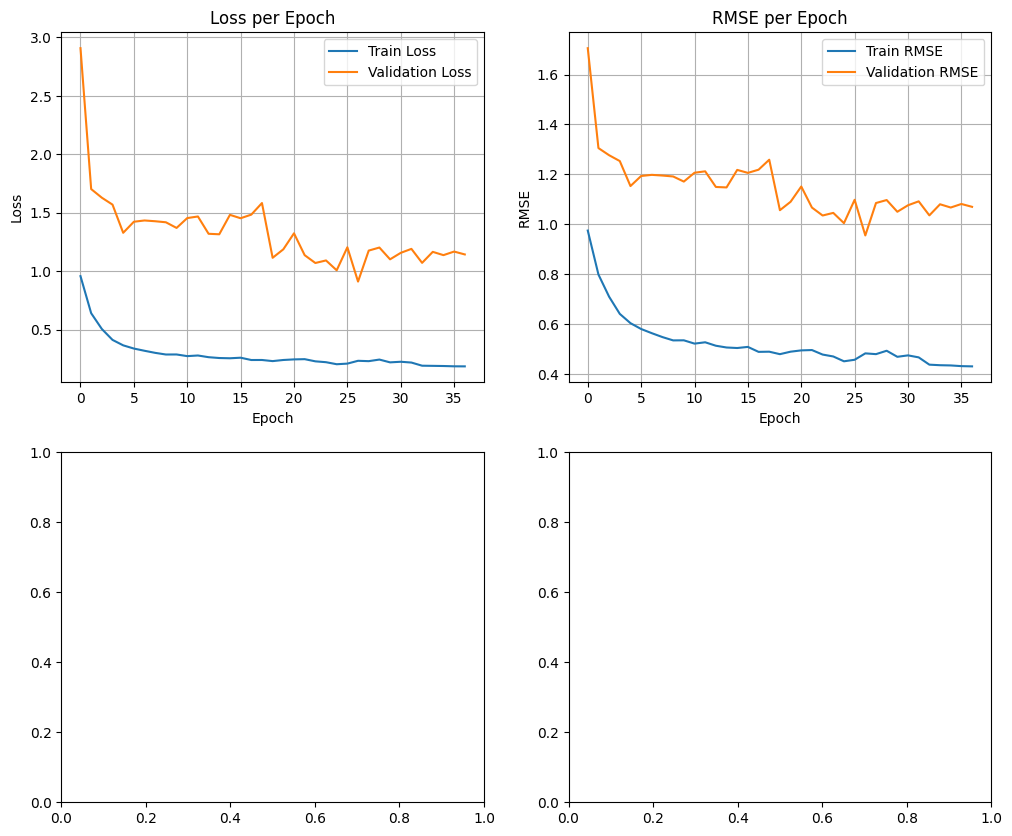

In [52]:
import models, visualizations,utils
reload(models)
reload(visualizations)
reload(utils)

from models import LSTMModel, train_and_evaluate_model
from visualizations import plot_prices_comparision, plot_metrics
from utils import get_company_list_from_directory,map_company_names_to_predictions 


directory = "data/probar"  # Replace with your actual directory path
companies = get_company_list_from_directory(directory)


# Entrenar el modelo LSTM Configuración buena 
input_size      = X_train_tensor.shape[2]  # Número de características de entrada
output_size     = y_train.shape[1]        # Número de empresas (salida)



hidden_size = 128
num_layers = 4
dropout_prob = 0.65
num_epochs = 50
learning_rate = 0.0001
weight_decay = 1e-4
optimizer_choice = 'adam'
critierion='MSE'
patience=10


model = LSTMModel(
    input_size=input_size,
    hidden_size=hidden_size,
    output_size=output_size,
    num_layers=num_layers,
    dropout_prob=dropout_prob,

)
file_name = f"{ventana}_{horizonte}_{hidden_size}_{num_layers}_{dropout_prob}_{num_epochs}_{learning_rate}_{weight_decay}_{optimizer_choice}_{critierion}"

print(f"Entrenando modelo LSTM con configuración {file_name}")
# train_model(model_lstm, train_loader, test_loader, num_epochs, learning_rate)
# lstm_preds, lstm_actuals = evaluate_model(model_lstm, test_loader)

trained_model, preds, actuals,metrics = train_and_evaluate_model(
    model, train_loader, test_loader, num_epochs, learning_rate,weight_decay,optimizer_choice,critierion,patience
)

# # Guardar predicciones con Pickle
# with open('lstm_preds.pkl', 'wb') as f:
#     pickle.dump(lstm_preds, f)

plot_metrics(metrics,'LSTM',str(len(companies)),guardar=True,file_name=file_name)
plot_prices_comparision(actuals,preds,'LSTM',scaler_y,len(companies),companies,guardar=True,file_name=file_name)




### MULTI-LSTM

### RNN 

Entrenando modelo RNN...
Epoch 1/15, Train Loss: 0.2305, Valid Loss: 0.1656, Train RMSE: 0.4804, Valid RMSE: 0.4070, Train R²: 0.7692, Valid R²: -110.6133
Epoch 2/15, Train Loss: 0.3501, Valid Loss: 0.7020, Train RMSE: 0.5929, Valid RMSE: 0.8378, Train R²: 0.6485, Valid R²: -309.6143
Epoch 3/15, Train Loss: 0.2242, Valid Loss: 0.9437, Train RMSE: 0.4745, Valid RMSE: 0.9714, Train R²: 0.7748, Valid R²: -385.8154
Epoch 4/15, Train Loss: 0.3463, Valid Loss: 0.0441, Train RMSE: 0.5895, Valid RMSE: 0.2100, Train R²: 0.6525, Valid R²: -31.1422
Epoch 5/15, Train Loss: 0.3688, Valid Loss: 0.1295, Train RMSE: 0.6085, Valid RMSE: 0.3599, Train R²: 0.6298, Valid R²: -66.9784
Epoch 6/15, Train Loss: 0.2218, Valid Loss: 0.1001, Train RMSE: 0.4717, Valid RMSE: 0.3163, Train R²: 0.7775, Valid R²: -40.7170
Epoch 7/15, Train Loss: 0.1615, Valid Loss: 0.0186, Train RMSE: 0.4020, Valid RMSE: 0.1363, Train R²: 0.8384, Valid R²: -8.8974
Epoch 8/15, Train Loss: 0.1355, Valid Loss: 0.0662, Train RMSE: 0.3684

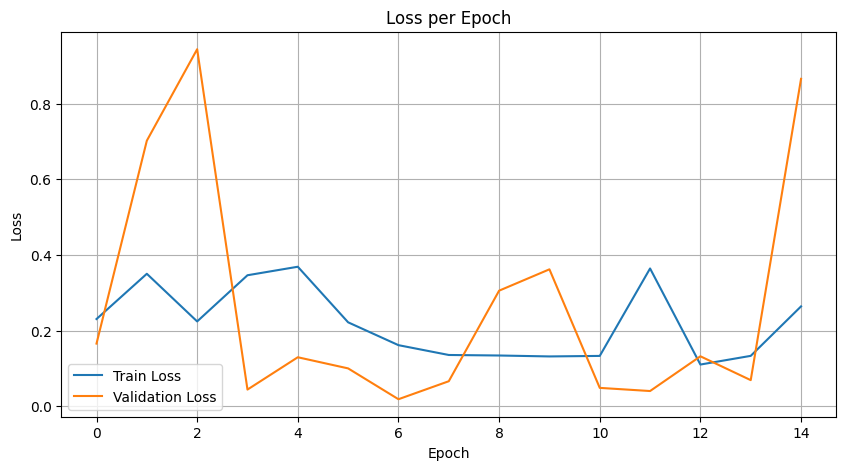

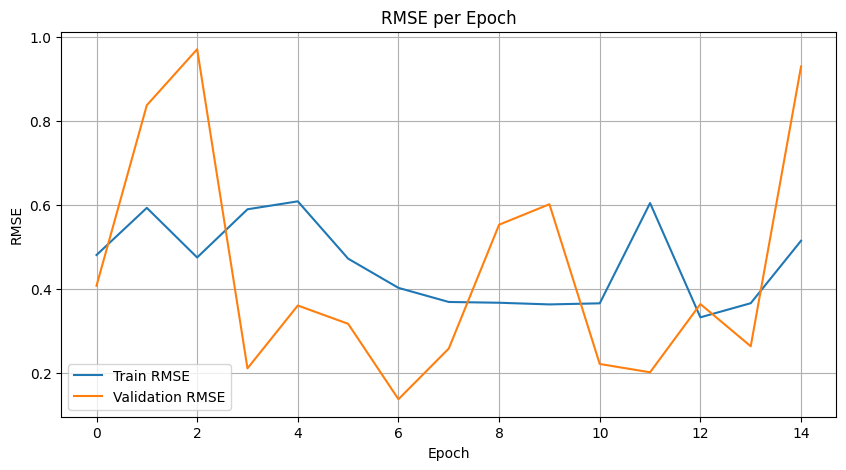

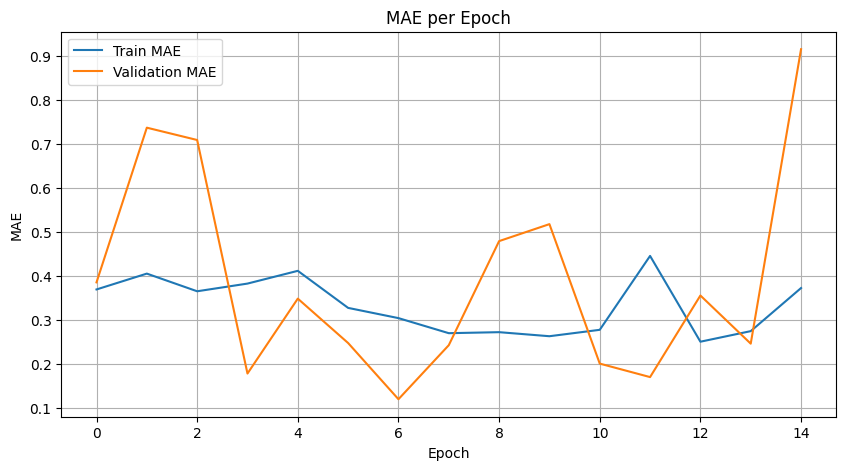

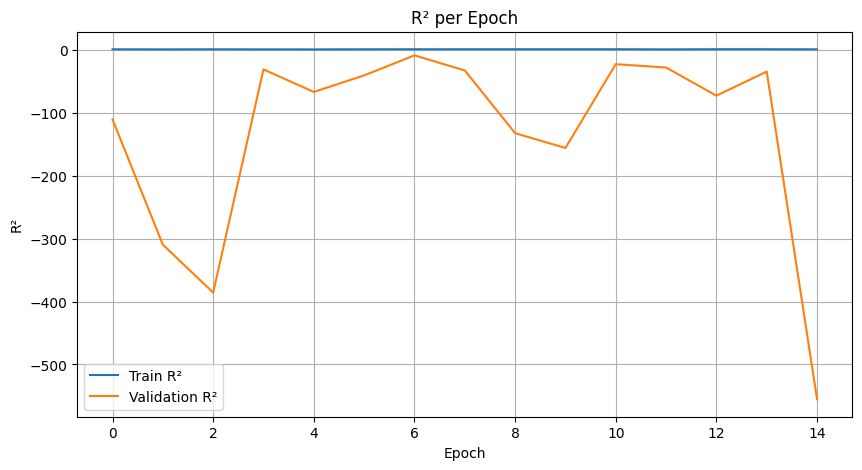

In [117]:
from models import RNNModel
model = RNNModel(input_size, hidden_size, output_size)

print("Entrenando modelo RNN...")
# train_model(model_lstm, train_loader, test_loader, num_epochs, learning_rate)
# RNN_preds, RNN_actuals = evaluate_model(model_lstm, test_loader)

# # Guardar predicciones con Pickle
# with open('lstm_preds.pkl', 'wb') as f:
#     pickle.dump(lstm_preds, f)



trained_model, preds, actuals,metrics = train_and_evaluate_model(
    model, train_loader, test_loader, num_epochs, learning_rate
)

# # Guardar predicciones con Pickle
# with open('lstm_preds.pkl', 'wb') as f:
#     pickle.dump(lstm_preds, f)

plot_metrics(metrics)


# **Portfolio Optimization**

# **Bibliograpghy**

- Wong, Albert, et al. “Short-Term Stock Price Forecasting Using Exogenous Variables and Machine Learning Algorithms.” ArXiv.org, 2023, arxiv.org/abs/2309.00618. Accessed 7 Dec. 2024.
- Gabriel, and Marcel Otoboni. “Previs\~Ao Dos Pre\C{C}Os de Abertura, M\'Inima E M\'Axima de \'Indices de Mercados Financeiros Usando a Associa\C{C}\~Ao de Redes Neurais LSTM.” ArXiv.org, 2021, arxiv.org/abs/2108.10065. Accessed 7 Dec. 2024.
- Orsel, Ogulcan E., and Sasha S. Yamada. “Comparative Study of Machine Learning Models for Stock Price Prediction.” ArXiv.org, 31 Jan. 2022, arxiv.org/abs/2202.03156.